# 🚀 Google Colab Kurulumu

Bu hücreyi sadece **Colab'da** çalıştır. Local'de çalışıyorsan atla.

In [1]:
# ============================================
# COLAB KURULUMU - Sadece Colab'da çalıştır!
# ============================================

# 1. Google Drive'ı bağla
from google.colab import drive
drive.mount('/content/drive')

# 2. Dataset ZIP'ini çıkar
# NOT: retinalData.zip dosyasını Drive'ın ana klasörüne (My Drive) yükle
!unzip -q "/content/drive/MyDrive/retinalData/retinalData.zip" -d "/content/dataset"

print("✅ Dataset hazır!")
print("📁 Konum: /content/dataset/retinalData/")

Mounted at /content/drive
✅ Dataset hazır!
📁 Konum: /content/dataset/retinalData/


In [2]:
# ==========================================
# CSV DOSYALARINI TEMİZLE (20'den az örnek)
# ==========================================
import pandas as pd

train_csv = '/content/dataset/retinalData/Training_Set/Training_Set/RFMiD_Training_Labels.csv'
val_csv = '/content/dataset/retinalData/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv'
test_csv = '/content/dataset/retinalData/Test_Set/Test_Set/RFMiD_Testing_Labels.csv'

# 20'den az örneği olan sınıflar
low_sample_classes = ['MS', 'AH', 'AION', 'EDN']

for csv_path in [train_csv, val_csv, test_csv]:
    df = pd.read_csv(csv_path)
    df = df.drop(columns=low_sample_classes, errors='ignore')
    df.to_csv(csv_path, index=False)
    print(f"✅ {csv_path.split('/')[-1]} güncellendi - {len(df.columns)-2} sınıf")

print(f"\n🗑️ Çıkarılan sınıflar: {low_sample_classes}")
print(f"📊 Kalan sınıf sayısı: 16")

✅ RFMiD_Training_Labels.csv güncellendi - 16 sınıf
✅ RFMiD_Validation_Labels.csv güncellendi - 16 sınıf
✅ RFMiD_Testing_Labels.csv güncellendi - 16 sınıf

🗑️ Çıkarılan sınıflar: ['MS', 'AH', 'AION', 'EDN']
📊 Kalan sınıf sayısı: 16


In [77]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Loading image and label paths

In [78]:
# Colab için: /content/dataset/retinalData
# Local için: kendi yolunu yaz
DATA_ROOT = '/content/dataset/retinalData'

train_dir = os.path.join(DATA_ROOT, 'Training_Set', 'Training_Set')
val_dir = os.path.join(DATA_ROOT, 'Evaluation_Set', 'Evaluation_Set')
test_dir = os.path.join(DATA_ROOT, 'Test_Set', 'Test_Set')

train_img_paths = glob.glob(os.path.join(train_dir, 'Training', '*.png'))
train_label_path = os.path.join(train_dir, 'RFMiD_Training_Labels.csv')

val_img_paths = glob.glob(os.path.join(val_dir, 'Validation', '*.png'))
val_label_path = os.path.join(val_dir, 'RFMiD_Validation_Labels.csv')

test_img_paths = glob.glob(os.path.join(test_dir, 'Test', '*.png'))
test_label_path = os.path.join(test_dir, 'RFMiD_Testing_Labels.csv')

len(train_img_paths), len(val_img_paths), len(test_img_paths)

(1920, 640, 640)

In [79]:
train_label_df = pd.read_csv(train_label_path)
val_label_df = pd.read_csv(val_label_path)
test_label_df = pd.read_csv(test_label_path)

print(f'Num. train labels: {len(train_label_df)}')
print(f'Num. val labels: {len(val_label_df)}')
print(f'Num. test labels: {len(test_label_df)}')

Num. train labels: 1920
Num. val labels: 640
Num. test labels: 640


In [80]:
# show labels in train set
train_label_df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,LS,CSR,ODC,CRVO,ODP,ODE,RS,CRS,RPEC
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


`Important note:` the index to the dataframe for each iamge sample is its ID (also name) - 1. With this out of the way, I won't talk about this again in the code below

# Visualizing the dataset

There are 47 columns. Out of which, the `ID` column is the retina image ID, `Disease_Risk` is a binary column representing whether the retina is normal or not. The remaining 45 columns are different types of retina diseases

In [81]:
train_label_df.columns, len(train_label_df.columns)

(Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
        'LS', 'CSR', 'ODC', 'CRVO', 'ODP', 'ODE', 'RS', 'CRS', 'RPEC'],
       dtype='object'),
 18)

Since this is a `multi-label classification` problem, each sample might have zero, one, or more than one true labels. In this case, each retina image might have multiple diseases. Let's plot it out!

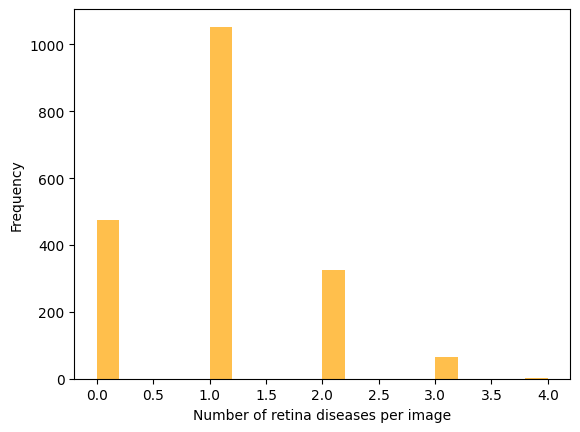

In [ ]:
n_diseases_per_sample = train_label_df.drop(columns=['ID', 'Disease_Risk']).sum(axis=1)

plt.hist(n_diseases_per_sample, bins=20, color='orange', alpha=0.7)
plt.xlabel('Number of retina diseases per image')
plt.ylabel('Frequency')
plt.savefig('images/diseases_per_sample_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

Let's plot a normal retinal image and one with 5 diseases to compare the differences

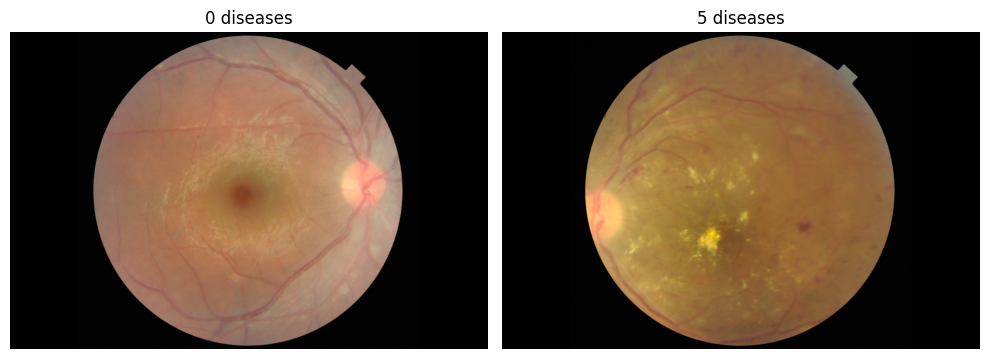

In [ ]:
id_0di = (n_diseases_per_sample == 0).idxmax()
id_5di = (n_diseases_per_sample == 5).idxmax()

img_0di_path = os.path.join(train_dir, 'Training', f'{id_0di+1}.png')
img_5di_path = os.path.join(train_dir, 'Training', f'{id_5di+1}.png')

def load_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

img_0di, img_5di = load_img(img_0di_path), load_img(img_5di_path)

# Plot the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_0di)
plt.title('0 diseases')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_5di)
plt.title('5 diseases')
plt.axis('off')

plt.tight_layout()
plt.savefig('images/disease_comparison_0_vs_5.png', dpi=300, bbox_inches='tight')
plt.show()

Now let's try from 0 to 5 diseases

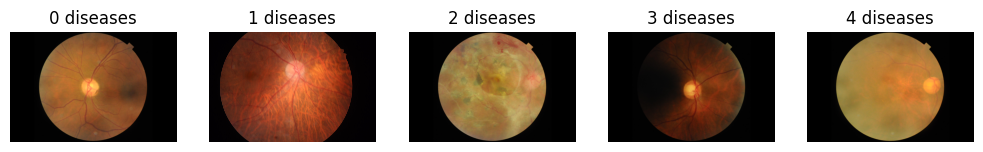

In [ ]:
plt.figure(figsize=(15, 5))
np.random.seed(42)

for i in range(6):  # 0 to 5 diseases
    indices_i = n_diseases_per_sample.index[n_diseases_per_sample == i].tolist()
    if indices_i:
        id_i = np.random.choice(indices_i)  # Get a random index for the current disease count
        img_i_path = os.path.join(train_dir, 'Training', f'{id_i+1}.png')
        img_i = load_img(img_i_path)

        plt.subplot(1, 6, i + 1)
        plt.imshow(img_i)
        plt.title(f'{i} diseases')
        plt.axis('off')

plt.savefig('images/disease_samples_0_to_5.png', dpi=300, bbox_inches='tight')
plt.show()

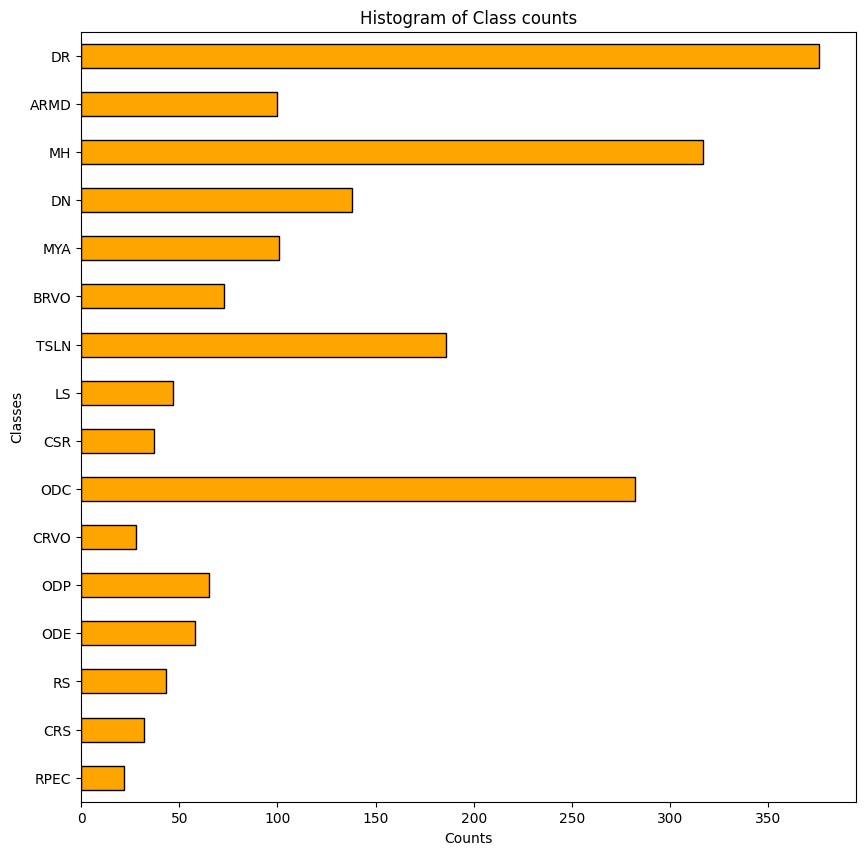

In [ ]:
classes_freq = train_label_df.drop(columns=['ID', 'Disease_Risk']).sum(axis=0)[::-1]

plt.figure(figsize=(10, 10))  # Adjust the width and height as needed
classes_freq.plot(kind='barh', color='orange', edgecolor='black')

plt.title('Histogram of Class counts')
plt.xlabel('Counts')
plt.ylabel('Classes')

plt.savefig('images/class_counts_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

## ✅ Dataset Temizlendi

Bu dataset'te 20'den az örneğe sahip sınıflar çıkarıldı. Artık tüm sınıflar yeterli örneğe sahip.

In [86]:
# Sınıf sayısını ve minimum örnek sayısını kontrol et
disease_cols = train_label_df.drop(columns=['ID', 'Disease_Risk']).columns
class_counts = train_label_df[disease_cols].sum()

print(f"Toplam sınıf sayısı: {len(disease_cols)}")
print(f"Minimum örnek sayısı: {class_counts.min()}")
print(f"Maksimum örnek sayısı: {class_counts.max()}")
print(f"\nSınıflar: {list(disease_cols)}")

Toplam sınıf sayısı: 16
Minimum örnek sayısı: 22
Maksimum örnek sayısı: 376

Sınıflar: ['DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN', 'LS', 'CSR', 'ODC', 'CRVO', 'ODP', 'ODE', 'RS', 'CRS', 'RPEC']


# Preprocessing data for training models

In [87]:
from torch.utils.data import Dataset
from PIL import Image

def path2id(img_path):
    return int(os.path.splitext(os.path.basename(img_path))[0])

class RetinaDataset(Dataset):

    def __init__(self, img_paths, label_csv_path, transform=None):
        self.img_paths = sorted(img_paths)
        # CSV zaten temizlenmiş, sadece ID ve Disease_Risk çıkar
        self.label_df = pd.read_csv(label_csv_path).drop(columns=['ID', 'Disease_Risk'])
        self.disease_columns = list(self.label_df.columns)
        self.transform = transform
        print(f"Dataset oluşturuldu: {len(self.img_paths)} görüntü, {len(self.disease_columns)} sınıf")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, id):
        img_path = self.img_paths[id]
        img_id = path2id(img_path)
        img = Image.open(img_path)
        label = np.array(self.label_df.iloc[img_id - 1]) # Index to frame is image ID - 1, see the note earlier
        if self.transform is not None:
            img = self.transform(img)
            label = torch.from_numpy(label).float()
            return img, label
        else:
            img = np.array(img)
            return img, label

In [88]:
# test the dataset correctness, without transform
ID = 0

data = RetinaDataset(train_img_paths, train_label_path)

img, label = data[ID]
img.shape, img.dtype, label.shape, label.dtype

Dataset oluşturuldu: 1920 görüntü, 16 sınıf


((1424, 2144, 3), dtype('uint8'), (16,), dtype('int64'))

Below we test out some transformations that PyTorch offers and visualize the result

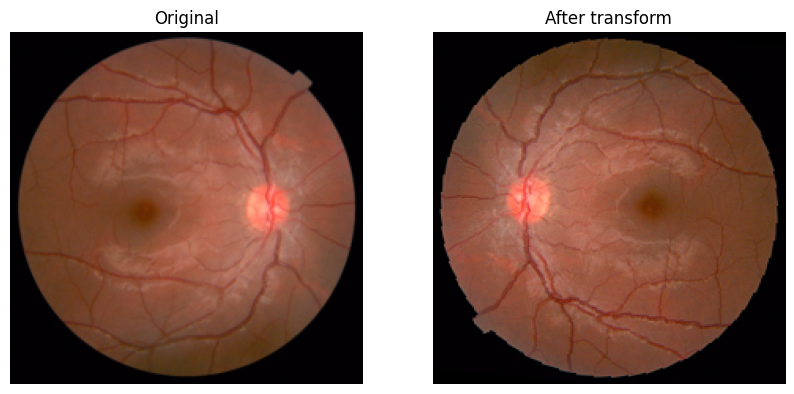

In [ ]:
import torchvision.transforms.v2 as transforms

img_path = train_img_paths[8]
img = Image.open(img_path)

tf1 = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
])

tf2 = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAdjustSharpness(2, 1),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(224),
])

img1, img2 = tf1(img), tf2(img)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original')
plt.imshow(img1)

plt.subplot(122)
plt.title('After transform')
plt.imshow(img2)
plt.axis('off')
plt.savefig('images/transform_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [90]:
(np.array(img1) != np.array(img2)).sum()

np.int64(117427)

In [91]:
import torchvision.transforms.v2 as transforms

PRET_MEANS = [0.485, 0.456, 0.406]
PRET_STDS = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAdjustSharpness(2, 0.8),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=PRET_MEANS, std=PRET_STDS)
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=PRET_MEANS, std=PRET_STDS)
])

In [92]:
train_data = RetinaDataset(train_img_paths, train_label_path, train_transform)
val_data = RetinaDataset(val_img_paths, val_label_path, test_transform)
test_data = RetinaDataset(test_img_paths, test_label_path, test_transform)

img, label = train_data[ID]
img.shape, img.dtype, label.shape, label.dtype

Dataset oluşturuldu: 1920 görüntü, 16 sınıf
Dataset oluşturuldu: 640 görüntü, 16 sınıf
Dataset oluşturuldu: 640 görüntü, 16 sınıf


(torch.Size([3, 224, 224]), torch.float32, torch.Size([16]), torch.float32)

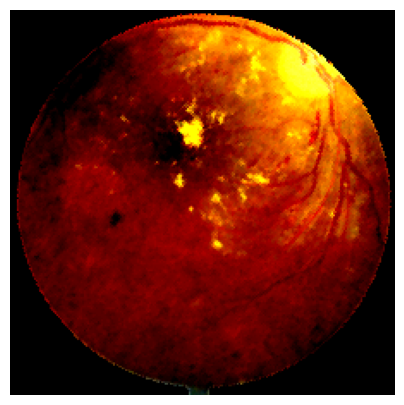

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(img.permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.savefig('images/sample_transformed_image.png', dpi=300, bbox_inches='tight')
plt.show()

In [94]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
# WEIGHT_DECAY = 1e-5
N_WORKERS = os.cpu_count()

train_loader = DataLoader(train_data,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=N_WORKERS,
                           pin_memory=True)

val_loader = DataLoader(val_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=N_WORKERS,
                         pin_memory=True)

test_loader = DataLoader(test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=N_WORKERS,
                         pin_memory=True)

# Model configuration

In [95]:
from torchvision import models
from torch import nn

model = models.convnext_tiny(weights='IMAGENET1K_V1')

# replace final layer in classifier
in_final = model.classifier[-1].in_features
# Sınıf sayısını CSV'den otomatik al
OUT_FINAL = len(train_label_df.drop(columns=['ID', 'Disease_Risk']).columns)
print(f"Model çıkış sınıf sayısı: {OUT_FINAL}")

model.classifier
model.classifier[-1] = nn.Linear(in_final, OUT_FINAL)

Model çıkış sınıf sayısı: 16


In [96]:
# Number of parameters
sum(p.numel() for p in model.parameters())

27832432

# Finding suitable Learning Rate

With learning rate annealing from the paper https://arxiv.org/abs/1506.01186

In [97]:
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler
from tqdm import tqdm

START_LR = 1e-7

optimizer = optim.AdamW(model.parameters(), lr=START_LR)
loss_fn = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)

class LRFinder:

    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), 'init_params.pt')

    def _train_batch(self, iterator):
        self.model.train()
        self.optimizer.zero_grad()
        x, y = iterator.get_batch()
        x = x.to(self.device)
        y = y.to(self.device)
        y_pred = model(x)
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def range_test(self, iterator, end_lr=10, num_iter=100,
                    smooth_f=0.05, diverge_th=5):
        lrs=[]
        losses=[]
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        iterator = IteratorWrapper(iterator)

        for iteration in tqdm(range(num_iter)):
            loss = self._train_batch(iterator)
            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
        return lrs, losses

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        cur_iter = self.last_epoch
        r = cur_iter / self.num_iter
        return [base_lr * ((self.end_lr / base_lr) ** r) for base_lr in self.base_lrs]

class IteratorWrapper():
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)
        return inputs, labels

    def get_batch(self):
        return next(self)

In [98]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, loss_fn, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

 84%|████████▍ | 84/100 [01:52<00:21,  1.34s/it]

Stopping early, the loss has diverged


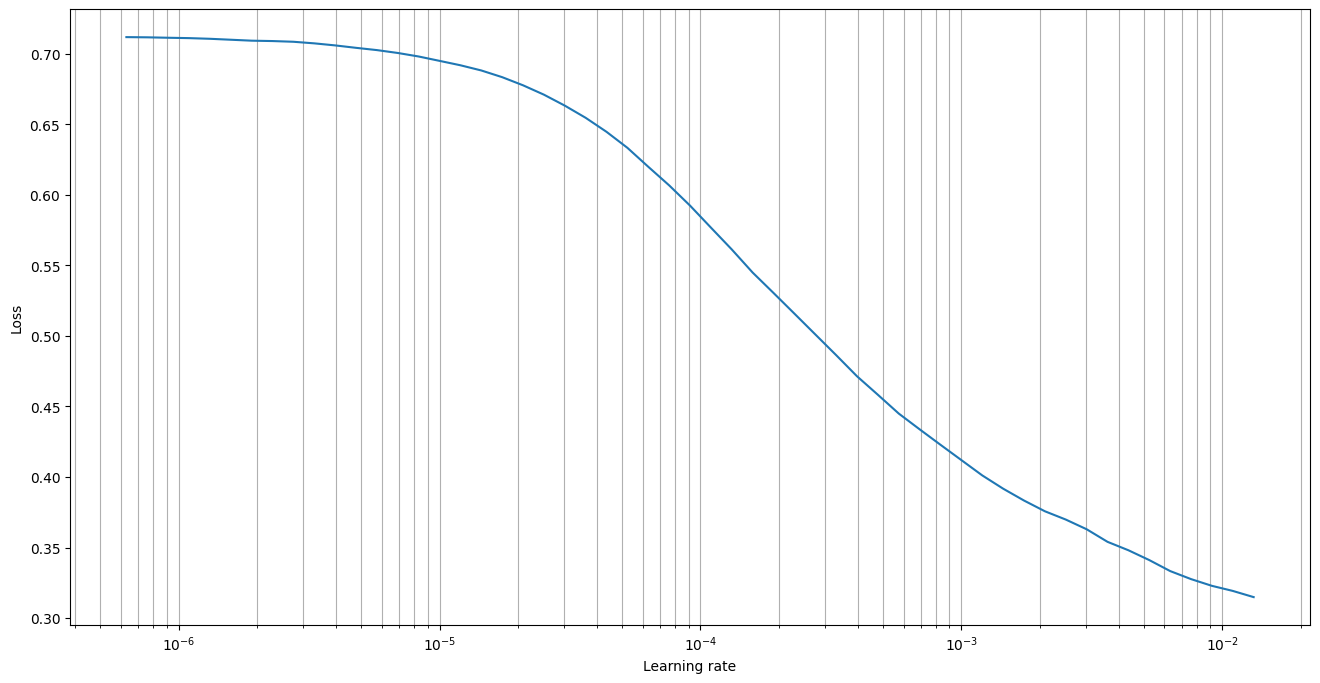

In [ ]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.savefig('images/lr_finder.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_lr_finder(lrs, losses, skip_start=10, skip_end=20)

As explained in the paper, the recommended LR should be the place where the loss is lowest divided by 10. In this case, the suitable LR should be 2e-3

# Training model

We will also use `discriminative fine-tuning` from the paper https://arxiv.org/abs/1801.06146

In [100]:
LR_FOUND = 2e-3

loss_fn = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)

# using smaller learning rate for feature extractor compared to classifier
lr_params = [
    {'params': model.features.parameters(), 'lr': LR_FOUND / 10},
    {'params': model.classifier.parameters(), 'lr': LR_FOUND}
]

optimizer = optim.AdamW(lr_params)

## 🔧 Class Imbalance Çözümleri

Veri setinde ciddi sınıf dengesizliği var. Aşağıda bu problemi çözmek için:
1. **Pos Weight (Class Weighting)**: Nadir sınıflara daha yüksek ağırlık
2. **Focal Loss**: Hard examples'a odaklanma
3. **Gelişmiş Data Augmentation**: RandAugment, ColorJitter, RandomErasing

In [101]:
# ==========================================
# 1. CLASS WEIGHTING (POS_WEIGHT) HESAPLAMA
# ==========================================

# Her sınıf için pozitif örnek sayısını hesapla
label_cols = train_label_df.drop(columns=['ID', 'Disease_Risk']).columns
pos_counts = train_label_df[label_cols].sum()
neg_counts = len(train_label_df) - pos_counts

# pos_weight = negative_samples / positive_samples (nadir sınıflara yüksek ağırlık)
pos_weight = neg_counts / (pos_counts + 1)  # +1 to avoid division by zero

# ⚠️ CLAMPING: Çok yüksek pos_weight değerleri False Positive'e neden olur
# Maksimum 10.0 ile sınırla (daha dengeli tahminler için)
MAX_POS_WEIGHT = 10.0
pos_weight = pos_weight.clip(upper=MAX_POS_WEIGHT)

pos_weight = torch.tensor(pos_weight.values, dtype=torch.float32).to(device)

print("Sınıf Ağırlıkları (pos_weight) - MAX:", MAX_POS_WEIGHT)
print("-" * 50)
for i, (col, weight) in enumerate(zip(label_cols, pos_weight.cpu().numpy())):
    count = int(pos_counts[col])
    clamped = " (clamped)" if weight == MAX_POS_WEIGHT else ""
    print(f"{col:8s}: {weight:8.2f} (n={count:4d}){clamped}")

# Weighted BCEWithLogitsLoss
weighted_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

Sınıf Ağırlıkları (pos_weight) - MAX: 10.0
--------------------------------------------------
DR      :     4.10 (n= 376)
ARMD    :    10.00 (n= 100) (clamped)
MH      :     5.04 (n= 317)
DN      :    10.00 (n= 138) (clamped)
MYA     :    10.00 (n= 101) (clamped)
BRVO    :    10.00 (n=  73) (clamped)
TSLN    :     9.27 (n= 186)
LS      :    10.00 (n=  47) (clamped)
CSR     :    10.00 (n=  37) (clamped)
ODC     :     5.79 (n= 282)
CRVO    :    10.00 (n=  28) (clamped)
ODP     :    10.00 (n=  65) (clamped)
ODE     :    10.00 (n=  58) (clamped)
RS      :    10.00 (n=  43) (clamped)
CRS     :    10.00 (n=  32) (clamped)
RPEC    :    10.00 (n=  22) (clamped)


In [102]:
# ==========================================
# 2. FOCAL LOSS IMPLEMENTATION
# ==========================================
# Focal Loss, kolay öğrenilen örneklerin etkisini azaltır
# ve zor örneklere odaklanır (özellikle nadir sınıflar için faydalı)

class FocalLoss(nn.Module):
    """
    Focal Loss for multi-label classification
    FL(p_t) = -alpha * (1 - p_t)^gamma * log(p_t)

    gamma: focusing parameter (0 = BCE, 2 tipik değer)
    alpha: class weighting (pos_weight ile birlikte kullanılabilir)
    """
    def __init__(self, gamma=2.0, alpha=None, pos_weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # scalar veya tensor olabilir
        self.pos_weight = pos_weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        # BCE with logits
        if self.pos_weight is not None:
            bce_loss = F.binary_cross_entropy_with_logits(
                inputs, targets, pos_weight=self.pos_weight, reduction='none'
            )
        else:
            bce_loss = F.binary_cross_entropy_with_logits(
                inputs, targets, reduction='none'
            )

        # Focal term: (1 - p_t)^gamma
        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        focal_loss = focal_weight * bce_loss

        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

import torch.nn.functional as F

# Focal Loss with class weighting
# gamma=2.5: Zor örneklere daha fazla odaklanma (nadir sınıflar için daha iyi)
# alpha=0.15: Azaltılmış alpha değeri False Positive'leri azaltır (0.25'ten düşürüldü)
focal_loss_fn = FocalLoss(gamma=2.5, alpha=0.15, pos_weight=pos_weight).to(device)
print("Focal Loss (gamma=2.5, alpha=0.15) with class weighting oluşturuldu.")

Focal Loss (gamma=2.5, alpha=0.15) with class weighting oluşturuldu.


In [103]:
# ==========================================
# 3. GELİŞMİŞ DATA AUGMENTATION
# ==========================================
import torchvision.transforms.v2 as transforms

# Daha agresif augmentation pipeline
advanced_train_transform = transforms.Compose([
    transforms.Resize(256),  # Biraz daha büyük resize

    # Renk augmentation'ları
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1
    ),

    # Geometrik augmentation'lar
    transforms.RandomAffine(
        degrees=180,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=10
    ),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),

    # Keskinlik ve blur
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),

    # Random erasing (Cutout benzeri)
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=PRET_MEANS, std=PRET_STDS),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])

print("Gelişmiş Data Augmentation pipeline oluşturuldu.")
print("Eklenen augmentation'lar:")
print("  - ColorJitter (brightness, contrast, saturation, hue)")
print("  - RandomAffine (rotation, translation, scale, shear)")
print("  - GaussianBlur")
print("  - RandomErasing (Cutout benzeri)")

Gelişmiş Data Augmentation pipeline oluşturuldu.
Eklenen augmentation'lar:
  - ColorJitter (brightness, contrast, saturation, hue)
  - RandomAffine (rotation, translation, scale, shear)
  - GaussianBlur
  - RandomErasing (Cutout benzeri)


In [104]:
# ==========================================
# 4. WEIGHTED RANDOM SAMPLER (OVERSAMPLING)
# ==========================================
from torch.utils.data import WeightedRandomSampler

# Her örneğe ağırlık ata (içerdiği nadir sınıflara göre)
def calculate_sample_weights(label_df, label_cols):
    """
    Her örnek için ağırlık hesapla.
    Nadir sınıflara sahip örnekler daha yüksek ağırlık alır.
    """
    labels = label_df[label_cols].values
    pos_counts = labels.sum(axis=0)

    # Her sınıfın ağırlığı (ters frekans)
    class_weights = 1.0 / (pos_counts + 1)
    class_weights = class_weights / class_weights.sum()  # normalize

    # Her örneğin ağırlığı = sahip olduğu sınıfların ağırlıklarının toplamı
    sample_weights = (labels * class_weights).sum(axis=1)

    # Hiç hastalığı olmayan örnekler için minimum ağırlık
    sample_weights = np.maximum(sample_weights, sample_weights[sample_weights > 0].min())

    return sample_weights

sample_weights = calculate_sample_weights(train_label_df, label_cols)
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

# WeightedRandomSampler oluştur
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # Oversampling için True
)

print(f"Sample weights hesaplandı (min: {sample_weights.min():.6f}, max: {sample_weights.max():.6f})")
print("WeightedRandomSampler oluşturuldu - nadir sınıflar daha sık örneklenecek.")

Sample weights hesaplandı (min: 0.009997, max: 0.220968)
WeightedRandomSampler oluşturuldu - nadir sınıflar daha sık örneklenecek.


In [105]:
# ==========================================
# 5. YENİ EĞİTİM KURULUMU (TÜM İYİLEŞTİRMELER)
# ==========================================

# Yeni data loader'lar (gelişmiş augmentation + weighted sampler)
train_data_v2 = RetinaDataset(train_img_paths, train_label_path, advanced_train_transform)

train_loader_v2 = DataLoader(
    train_data_v2,
    batch_size=BATCH_SIZE,
    sampler=weighted_sampler,  # shuffle yerine sampler kullan
    num_workers=N_WORKERS,
    pin_memory=True
)

# Model yeniden oluştur (fresh start)
model_v2 = models.convnext_tiny(weights='IMAGENET1K_V1')
in_final = model_v2.classifier[-1].in_features
model_v2.classifier[-1] = nn.Linear(in_final, OUT_FINAL)
model_v2 = model_v2.to(device)

# Discriminative fine-tuning - biraz daha düşük LR
lr_params_v2 = [
    {'params': model_v2.features.parameters(), 'lr': LR_FOUND / 15},  # 10'dan 15'e - daha yavaş feature learning
    {'params': model_v2.classifier.parameters(), 'lr': LR_FOUND * 0.8}  # Classifier için de biraz düşük
]
optimizer_v2 = optim.AdamW(lr_params_v2, weight_decay=1e-4)

# Learning rate scheduler (cosine annealing) - T_max 50 epoch'a göre ayarlandı
scheduler_v2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_v2, T_max=50, eta_min=1e-7)

print("=" * 60)
print("YENİ EĞİTİM KURULUMU TAMAMLANDI")
print("=" * 60)
print("✓ Gelişmiş Data Augmentation (ColorJitter, RandomAffine, etc.)")
print("✓ Weighted Random Sampler (Oversampling)")
print("✓ Focal Loss (gamma=2.5) + Class Weighting")
print("✓ Cosine Annealing LR Scheduler (T_max=50)")
print("✓ Early Stopping Patience: 8")
print("✓ Weight Decay: 1e-4")
print("=" * 60)

Dataset oluşturuldu: 1920 görüntü, 16 sınıf
YENİ EĞİTİM KURULUMU TAMAMLANDI
✓ Gelişmiş Data Augmentation (ColorJitter, RandomAffine, etc.)
✓ Weighted Random Sampler (Oversampling)
✓ Focal Loss (gamma=2.5) + Class Weighting
✓ Cosine Annealing LR Scheduler (T_max=50)
✓ Early Stopping Patience: 8
✓ Weight Decay: 1e-4


In [106]:
# ==========================================
# 6. EĞİTİM DÖNGÜSÜ (THRESHOLD OPTİMİZASYON İLE)
# ==========================================
from sklearn.metrics import precision_recall_curve
import numpy as np

def accuracy(y_h, y):
    y_h = (y_h > 0.5).float()
    return (y_h == y).float().mean(dim=1).mean()

def eval(model, loader, loss_fn, device):
    model.eval()
    lossi, acci = [], []

    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluation'):
            x, y = x.to(device), y.to(device)
            y_h = model(x)
            loss = loss_fn(y_h, y)
            lossi.append(loss.item())

            y_h, y = y_h.detach().cpu(), y.detach().cpu()
            acc = accuracy(y_h, y)
            acci.append(acc)

    loss = torch.tensor(lossi).mean().item()
    acc = torch.tensor(acci).mean().item()
    return {'loss': loss, 'acc': acc}

def find_optimal_thresholds_fast(all_preds, all_labels, label_cols, min_recall=0.3, max_threshold=0.7):
    """
    Her sınıf için F1'i maksimize eden optimal threshold bulur.
    Minimum recall garantisi ile threshold'un çok yüksek olmasını önler.

    Args:
        min_recall: Minimum kabul edilebilir recall (default: 0.3)
        max_threshold: Maximum threshold değeri (default: 0.7)
    """
    optimal_thresholds = {}

    for i, class_name in enumerate(label_cols):
        y_true = all_labels[:, i]
        y_scores = all_preds[:, i]

        if y_true.sum() == 0:
            optimal_thresholds[class_name] = 0.5
            continue

        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

        if len(thresholds) > 0:
            # F1'i maksimize eden threshold'u bul
            best_idx = np.argmax(f1_scores[:-1])
            best_threshold = float(thresholds[best_idx])

            # Minimum recall garantisi: Eğer recall çok düşükse threshold'u düşür
            best_recall = recall[best_idx]
            if best_recall < min_recall:
                # min_recall'ı sağlayan en yüksek threshold'u bul
                valid_indices = np.where(recall[:-1] >= min_recall)[0]
                if len(valid_indices) > 0:
                    # Bu indeksler arasında en yüksek F1'i seç
                    valid_f1 = f1_scores[:-1][valid_indices]
                    best_valid_idx = valid_indices[np.argmax(valid_f1)]
                    best_threshold = float(thresholds[best_valid_idx])

            # Maximum threshold sınırı
            best_threshold = min(best_threshold, max_threshold)

            optimal_thresholds[class_name] = best_threshold
        else:
            optimal_thresholds[class_name] = 0.5

    return optimal_thresholds

def eval_with_threshold_optimization(model, loader, loss_fn, device, label_cols):
    """
    Validation sırasında optimal threshold bularak F1 hesaplar.
    Early stopping için F1 score kullanır (loss yerine).
    """
    model.eval()
    lossi = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader, desc='Eval + Threshold Opt'):
            x, y = x.to(device), y.to(device)
            y_h = model(x)
            loss = loss_fn(y_h, y)
            lossi.append(loss.item())

            # Sigmoid uygula ve topla
            y_h_sigmoid = torch.sigmoid(y_h)
            all_preds.append(y_h_sigmoid.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    loss = np.mean(lossi)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Optimal thresholds bul
    optimal_thresholds = find_optimal_thresholds_fast(all_preds, all_labels, label_cols)

    # Optimal thresholds ile F1 hesapla
    f1_scores = []
    precision_scores = []
    recall_scores = []

    for i, class_name in enumerate(label_cols):
        y_true = all_labels[:, i]
        y_scores = all_preds[:, i]
        threshold = optimal_thresholds[class_name]

        y_pred = (y_scores >= threshold).astype(int)

        tp = ((y_pred == 1) & (y_true == 1)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()

        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * precision * recall / (precision + recall + 1e-10)

        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)

    macro_f1 = np.mean(f1_scores)
    macro_precision = np.mean(precision_scores)
    macro_recall = np.mean(recall_scores)

    return {
        'loss': loss,
        'macro_f1': macro_f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'optimal_thresholds': optimal_thresholds,
        'class_f1': dict(zip(label_cols, f1_scores))
    }

def train_epoch_v2(model, loader, loss_fn, optimizer, scheduler, device, epoch):
    """Geliştirilmiş training epoch"""
    model.train()
    lossi, acci = [], []

    for x, y in tqdm(loader, desc=f'Epoch {epoch}'):
        x, y = x.to(device), y.to(device)
        y_h = model(x)
        loss = loss_fn(y_h, y)
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping (stabilite için)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        lossi.append(loss.item())

        y_h, y = y_h.detach().cpu(), y.detach().cpu()
        acc = accuracy(y_h, y)
        acci.append(acc)

    scheduler.step()  # LR update

    loss = torch.tensor(lossi).mean().item()
    acc = torch.tensor(acci).mean().item()
    return {'loss': loss, 'acc': acc}

# Eğitimi başlat (Threshold Optimization ile)
N_EPOCHS_V2 = 50
best_f1_v2 = 0.0  # Loss yerine F1 kullan
best_thresholds = {}
train_resi_v2, val_resi_v2 = [], []
BEST_MODEL_V2 = ''
no_improvement_count_v2 = 0
max_no_improvement_v2 = 8

print("\n🚀 İyileştirilmiş model eğitimi başlıyor (Threshold Optimization ile)...")
print(f"Epochs: {N_EPOCHS_V2}, Early stopping patience: {max_no_improvement_v2}")
print("💡 Her epoch'ta optimal threshold hesaplanıyor, F1 score'a göre model seçimi yapılıyor\n")

for epoch in range(N_EPOCHS_V2):
    train_res = train_epoch_v2(model_v2, train_loader_v2, focal_loss_fn,
                               optimizer_v2, scheduler_v2, device, epoch+1)

    # Threshold optimization ile validation
    val_res = eval_with_threshold_optimization(model_v2, val_loader, focal_loss_fn, device, label_cols)

    current_lr = optimizer_v2.param_groups[-1]['lr']

    print(f'Epoch {epoch+1}/{N_EPOCHS_V2} | LR: {current_lr:.2e}')
    print(f"  Train  - Loss: {train_res['loss']:.4f} | Acc: {train_res['acc']:.3f}")
    print(f"  Valid  - Loss: {val_res['loss']:.4f} | F1: {val_res['macro_f1']:.4f} | Prec: {val_res['macro_precision']:.4f} | Rec: {val_res['macro_recall']:.4f}")

    # F1 score'a göre en iyi model seç (Loss yerine)
    if val_res['macro_f1'] > best_f1_v2:
        best_f1_v2 = val_res['macro_f1']
        best_thresholds = val_res['optimal_thresholds']
        BEST_MODEL_V2 = f'convnext_threshold_opt_cp_{epoch+1}.pth'
        torch.save(model_v2.state_dict(), BEST_MODEL_V2)

        # Optimal thresholds'ları da kaydet
        import json
        with open('best_thresholds.json', 'w') as f:
            json.dump(best_thresholds, f, indent=2)

        print(f'  ★ Yeni en iyi model! F1: {best_f1_v2:.4f}')
        print(f'    Thresholds kaydedildi: best_thresholds.json')
        no_improvement_count_v2 = 0
    else:
        no_improvement_count_v2 += 1
        print(f'  (İyileşme yok: {no_improvement_count_v2}/{max_no_improvement_v2})')

    if no_improvement_count_v2 >= max_no_improvement_v2:
        print(f'\n⚠️ {max_no_improvement_v2} epoch boyunca F1 iyileşmedi. Eğitim durduruluyor.')
        break

    train_resi_v2.append(train_res)
    val_resi_v2.append(val_res)
    print()

print(f"\n✅ Eğitim tamamlandı!")
print(f"   En iyi model: {BEST_MODEL_V2}")
print(f"   En iyi F1: {best_f1_v2:.4f}")
print(f"   Optimal thresholds: best_thresholds.json")

# En iyi threshold'ları göster
print("\n📊 Optimal Thresholds (Per-Class):")
print("-" * 40)
for class_name, threshold in best_thresholds.items():
    print(f"  {class_name:10s}: {threshold:.3f}")


🚀 İyileştirilmiş model eğitimi başlıyor (Threshold Optimization ile)...
Epochs: 50, Early stopping patience: 8
💡 Her epoch'ta optimal threshold hesaplanıyor, F1 score'a göre model seçimi yapılıyor



Eval + Threshold Opt: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


Epoch 1/50 | LR: 1.60e-03
  Train  - Loss: 0.0442 | Acc: 0.936
  Valid  - Loss: 0.0359 | F1: 0.3744 | Prec: 0.3232 | Rec: 0.5557
  ★ Yeni en iyi model! F1: 0.3744
    Thresholds kaydedildi: best_thresholds.json



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


Epoch 2/50 | LR: 1.59e-03
  Train  - Loss: 0.0302 | Acc: 0.947
  Valid  - Loss: 0.0303 | F1: 0.4567 | Prec: 0.4410 | Rec: 0.5934
  ★ Yeni en iyi model! F1: 0.4567
    Thresholds kaydedildi: best_thresholds.json



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


Epoch 3/50 | LR: 1.59e-03
  Train  - Loss: 0.0258 | Acc: 0.950
  Valid  - Loss: 0.0300 | F1: 0.5155 | Prec: 0.4762 | Rec: 0.6463
  ★ Yeni en iyi model! F1: 0.5155
    Thresholds kaydedildi: best_thresholds.json



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


Epoch 4/50 | LR: 1.57e-03
  Train  - Loss: 0.0222 | Acc: 0.957
  Valid  - Loss: 0.0284 | F1: 0.5444 | Prec: 0.5527 | Rec: 0.5965
  ★ Yeni en iyi model! F1: 0.5444
    Thresholds kaydedildi: best_thresholds.json



Eval + Threshold Opt: 100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Epoch 5/50 | LR: 1.56e-03
  Train  - Loss: 0.0215 | Acc: 0.957
  Valid  - Loss: 0.0277 | F1: 0.5764 | Prec: 0.5585 | Rec: 0.6664
  ★ Yeni en iyi model! F1: 0.5764
    Thresholds kaydedildi: best_thresholds.json



Eval + Threshold Opt: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


Epoch 6/50 | LR: 1.54e-03
  Train  - Loss: 0.0177 | Acc: 0.961
  Valid  - Loss: 0.0274 | F1: 0.5974 | Prec: 0.6080 | Rec: 0.6709
  ★ Yeni en iyi model! F1: 0.5974
    Thresholds kaydedildi: best_thresholds.json



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


Epoch 7/50 | LR: 1.52e-03
  Train  - Loss: 0.0160 | Acc: 0.964
  Valid  - Loss: 0.0277 | F1: 0.6051 | Prec: 0.5900 | Rec: 0.7089
  ★ Yeni en iyi model! F1: 0.6051
    Thresholds kaydedildi: best_thresholds.json



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


Epoch 8/50 | LR: 1.50e-03
  Train  - Loss: 0.0142 | Acc: 0.969
  Valid  - Loss: 0.0281 | F1: 0.6106 | Prec: 0.6046 | Rec: 0.7049
  ★ Yeni en iyi model! F1: 0.6106
    Thresholds kaydedildi: best_thresholds.json



Eval + Threshold Opt: 100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


Epoch 9/50 | LR: 1.48e-03
  Train  - Loss: 0.0143 | Acc: 0.969
  Valid  - Loss: 0.0290 | F1: 0.6085 | Prec: 0.5861 | Rec: 0.7070
  (İyileşme yok: 1/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


Epoch 10/50 | LR: 1.45e-03
  Train  - Loss: 0.0122 | Acc: 0.972
  Valid  - Loss: 0.0306 | F1: 0.6225 | Prec: 0.5965 | Rec: 0.7058
  ★ Yeni en iyi model! F1: 0.6225
    Thresholds kaydedildi: best_thresholds.json



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


Epoch 11/50 | LR: 1.42e-03
  Train  - Loss: 0.0122 | Acc: 0.973
  Valid  - Loss: 0.0302 | F1: 0.6092 | Prec: 0.5916 | Rec: 0.6864
  (İyileşme yok: 1/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Epoch 12/50 | LR: 1.38e-03
  Train  - Loss: 0.0107 | Acc: 0.976
  Valid  - Loss: 0.0310 | F1: 0.6143 | Prec: 0.5822 | Rec: 0.6996
  (İyileşme yok: 2/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


Epoch 13/50 | LR: 1.35e-03
  Train  - Loss: 0.0096 | Acc: 0.978
  Valid  - Loss: 0.0340 | F1: 0.6270 | Prec: 0.6224 | Rec: 0.6834
  ★ Yeni en iyi model! F1: 0.6270
    Thresholds kaydedildi: best_thresholds.json



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


Epoch 14/50 | LR: 1.31e-03
  Train  - Loss: 0.0093 | Acc: 0.979
  Valid  - Loss: 0.0302 | F1: 0.6457 | Prec: 0.6174 | Rec: 0.7212
  ★ Yeni en iyi model! F1: 0.6457
    Thresholds kaydedildi: best_thresholds.json



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


Epoch 15/50 | LR: 1.27e-03
  Train  - Loss: 0.0096 | Acc: 0.978
  Valid  - Loss: 0.0373 | F1: 0.6276 | Prec: 0.6446 | Rec: 0.6449
  (İyileşme yok: 1/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


Epoch 16/50 | LR: 1.23e-03
  Train  - Loss: 0.0087 | Acc: 0.981
  Valid  - Loss: 0.0349 | F1: 0.6406 | Prec: 0.6448 | Rec: 0.6575
  (İyileşme yok: 2/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


Epoch 17/50 | LR: 1.19e-03
  Train  - Loss: 0.0081 | Acc: 0.982
  Valid  - Loss: 0.0368 | F1: 0.6312 | Prec: 0.6463 | Rec: 0.6672
  (İyileşme yok: 3/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


Epoch 18/50 | LR: 1.14e-03
  Train  - Loss: 0.0084 | Acc: 0.982
  Valid  - Loss: 0.0334 | F1: 0.6284 | Prec: 0.6230 | Rec: 0.6686
  (İyileşme yok: 4/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


Epoch 19/50 | LR: 1.09e-03
  Train  - Loss: 0.0071 | Acc: 0.984
  Valid  - Loss: 0.0349 | F1: 0.6463 | Prec: 0.6852 | Rec: 0.6565
  ★ Yeni en iyi model! F1: 0.6463
    Thresholds kaydedildi: best_thresholds.json



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


Epoch 20/50 | LR: 1.05e-03
  Train  - Loss: 0.0075 | Acc: 0.984
  Valid  - Loss: 0.0360 | F1: 0.6387 | Prec: 0.6589 | Rec: 0.6707
  (İyileşme yok: 1/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


Epoch 21/50 | LR: 9.99e-04
  Train  - Loss: 0.0058 | Acc: 0.987
  Valid  - Loss: 0.0388 | F1: 0.6391 | Prec: 0.6369 | Rec: 0.6815
  (İyileşme yok: 2/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Epoch 22/50 | LR: 9.50e-04
  Train  - Loss: 0.0055 | Acc: 0.988
  Valid  - Loss: 0.0379 | F1: 0.6327 | Prec: 0.6585 | Rec: 0.6625
  (İyileşme yok: 3/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


Epoch 23/50 | LR: 9.00e-04
  Train  - Loss: 0.0056 | Acc: 0.988
  Valid  - Loss: 0.0412 | F1: 0.6372 | Prec: 0.6306 | Rec: 0.7235
  (İyileşme yok: 4/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


Epoch 24/50 | LR: 8.50e-04
  Train  - Loss: 0.0058 | Acc: 0.988
  Valid  - Loss: 0.0371 | F1: 0.6390 | Prec: 0.6416 | Rec: 0.6870
  (İyileşme yok: 5/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


Epoch 25/50 | LR: 8.00e-04
  Train  - Loss: 0.0051 | Acc: 0.988
  Valid  - Loss: 0.0397 | F1: 0.6404 | Prec: 0.6606 | Rec: 0.6720
  (İyileşme yok: 6/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


Epoch 26/50 | LR: 7.50e-04
  Train  - Loss: 0.0043 | Acc: 0.989
  Valid  - Loss: 0.0408 | F1: 0.6403 | Prec: 0.6567 | Rec: 0.6617
  (İyileşme yok: 7/8)



Eval + Threshold Opt: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


Epoch 27/50 | LR: 7.00e-04
  Train  - Loss: 0.0045 | Acc: 0.990
  Valid  - Loss: 0.0435 | F1: 0.6294 | Prec: 0.6267 | Rec: 0.6783
  (İyileşme yok: 8/8)

⚠️ 8 epoch boyunca F1 iyileşmedi. Eğitim durduruluyor.

✅ Eğitim tamamlandı!
   En iyi model: convnext_threshold_opt_cp_19.pth
   En iyi F1: 0.6463
   Optimal thresholds: best_thresholds.json

📊 Optimal Thresholds (Per-Class):
----------------------------------------
  DR        : 0.533
  ARMD      : 0.647
  MH        : 0.364
  DN        : 0.523
  MYA       : 0.385
  BRVO      : 0.656
  TSLN      : 0.510
  LS        : 0.374
  CSR       : 0.315
  ODC       : 0.473
  CRVO      : 0.445
  ODP       : 0.192
  ODE       : 0.700
  RS        : 0.568
  CRS       : 0.412
  RPEC      : 0.174


In [107]:
# ==========================================
# 7. KARŞILAŞTIRMALI DEĞERLENDİRME (Optimal Thresholds ile)
# ==========================================

def eval3_with_thresholds(model, loader, device, thresholds, label_cols):
    """
    Optimal thresholds kullanarak test seti değerlendirmesi yapar.
    Her sınıf için farklı threshold kullanır.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluation with optimal thresholds'):
            x = x.to(device)
            y_h = torch.sigmoid(model(x))
            all_preds.append(y_h.cpu().numpy())
            all_labels.append(y.numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Her sınıf için metrikleri hesapla
    precision_list = []
    recall_list = []
    f1_list = []

    for i, class_name in enumerate(label_cols):
        y_true = all_labels[:, i]
        y_scores = all_preds[:, i]
        threshold = thresholds.get(class_name, 0.5)

        y_pred = (y_scores >= threshold).astype(int)

        tp = ((y_pred == 1) & (y_true == 1)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()

        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * precision * recall / (precision + recall + 1e-10)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    return {
        'precision': torch.tensor(precision_list),
        'recall': torch.tensor(recall_list),
        'f1': torch.tensor(f1_list)
    }

# Sabit 0.5 threshold ile değerlendirme (baseline)
def eval3(model, loader, device):
    """Sabit 0.5 threshold ile değerlendirme (karşılaştırma için)"""
    true_pos = torch.zeros(len(label_cols))
    false_pos = torch.zeros(len(label_cols))
    false_neg = torch.zeros(len(label_cols))

    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluation (threshold=0.5)'):
            x, y = x.to(device), y.to(device)
            y_h = torch.sigmoid(model(x))
            y_h, y = y_h.detach().cpu(), y.detach().cpu()

            y_pred = (y_h > 0.5).float()
            true_pos += torch.sum((y_pred == 1) & (y == 1), dim=0)
            false_pos += torch.sum((y_pred == 1) & (y == 0), dim=0)
            false_neg += torch.sum((y_pred == 0) & (y == 1), dim=0)

    precision = true_pos / (true_pos + false_pos + 1e-10)
    recall = true_pos / (true_pos + false_neg + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    return {'precision': precision, 'recall': recall, 'f1': f1}

# En iyi modeli yükle
model_v2.load_state_dict(torch.load(BEST_MODEL_V2))

# Best thresholds'ı yükle
import json
with open('best_thresholds.json', 'r') as f:
    best_thresholds = json.load(f)

print("=" * 80)
print("📊 TEST SETİ DEĞERLENDİRMESİ")
print("=" * 80)

# 1. Sabit 0.5 threshold ile
print("\n🔹 Sabit Threshold (0.5) ile sonuçlar:")
test_result_fixed = eval3(model_v2, test_loader, device)

# 2. Optimal thresholds ile
print("\n🔹 Optimal Thresholds ile sonuçlar:")
test_result_optimal = eval3_with_thresholds(model_v2, test_loader, device, best_thresholds, label_cols)

# Karşılaştırma tablosu
print("\n" + "=" * 80)
print("📊 THRESHOLD KARŞILAŞTIRMASI (Test Seti)")
print("=" * 80)
print(f"\n{'Sınıf':<8} | {'Threshold':>9} | {'F1 (0.5)':>10} | {'F1 (Opt)':>10} | {'Fark':>8} | {'Prec':>6} | {'Rec':>6}")
print("-" * 75)

total_f1_improvement = 0
for i, col in enumerate(label_cols):
    f1_fixed = test_result_fixed['f1'][i].item()
    f1_optimal = test_result_optimal['f1'][i].item()
    diff = f1_optimal - f1_fixed
    total_f1_improvement += diff

    threshold = best_thresholds.get(col, 0.5)
    prec = test_result_optimal['precision'][i].item()
    rec = test_result_optimal['recall'][i].item()

    # Nadir sınıfları vurgula
    count = int(pos_counts[col])
    marker = "🔴" if count < 50 else "🟡" if count < 100 else ""

    print(f"{col:<8} | {threshold:>9.3f} | {f1_fixed:>10.3f} | {f1_optimal:>10.3f} | {diff:>+8.3f} | {prec:>6.3f} | {rec:>6.3f} {marker}")

print("-" * 75)

# Özet istatistikler
macro_f1_fixed = test_result_fixed['f1'].mean().item()
macro_f1_optimal = test_result_optimal['f1'].mean().item()
macro_prec_optimal = test_result_optimal['precision'].mean().item()
macro_rec_optimal = test_result_optimal['recall'].mean().item()

print(f"\n📈 ÖZET METRİKLER:")
print(f"   Macro F1 (Sabit 0.5):     {macro_f1_fixed:.4f}")
print(f"   Macro F1 (Optimal):       {macro_f1_optimal:.4f}")
print(f"   F1 İyileşmesi:            {macro_f1_optimal - macro_f1_fixed:+.4f}")
print(f"   Macro Precision (Optimal): {macro_prec_optimal:.4f}")
print(f"   Macro Recall (Optimal):    {macro_rec_optimal:.4f}")

📊 TEST SETİ DEĞERLENDİRMESİ

🔹 Sabit Threshold (0.5) ile sonuçlar:


Evaluation (threshold=0.5): 100%|██████████| 10/10 [00:25<00:00,  2.57s/it]



🔹 Optimal Thresholds ile sonuçlar:


Evaluation with optimal thresholds: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]



📊 THRESHOLD KARŞILAŞTIRMASI (Test Seti)

Sınıf    | Threshold |   F1 (0.5) |   F1 (Opt) |     Fark |   Prec |    Rec
---------------------------------------------------------------------------
DR       |     0.533 |      0.823 |      0.817 |   -0.006 |  0.789 |  0.847 
ARMD     |     0.647 |      0.658 |      0.656 |   -0.002 |  0.667 |  0.645 
MH       |     0.364 |      0.784 |      0.745 |   -0.040 |  0.677 |  0.827 
DN       |     0.523 |      0.400 |      0.391 |   -0.009 |  0.415 |  0.370 
MYA      |     0.385 |      0.731 |      0.750 |   +0.019 |  0.875 |  0.656 
BRVO     |     0.656 |      0.756 |      0.769 |   +0.014 |  0.937 |  0.652 🟡
TSLN     |     0.510 |      0.610 |      0.621 |   +0.011 |  0.571 |  0.679 
LS       |     0.374 |      0.333 |      0.417 |   +0.083 |  0.556 |  0.333 🔴
CSR      |     0.315 |      0.526 |      0.640 |   +0.114 |  0.667 |  0.615 🔴
ODC      |     0.473 |      0.576 |      0.567 |   -0.009 |  0.552 |  0.582 
CRVO     |     0.445 |      0.750

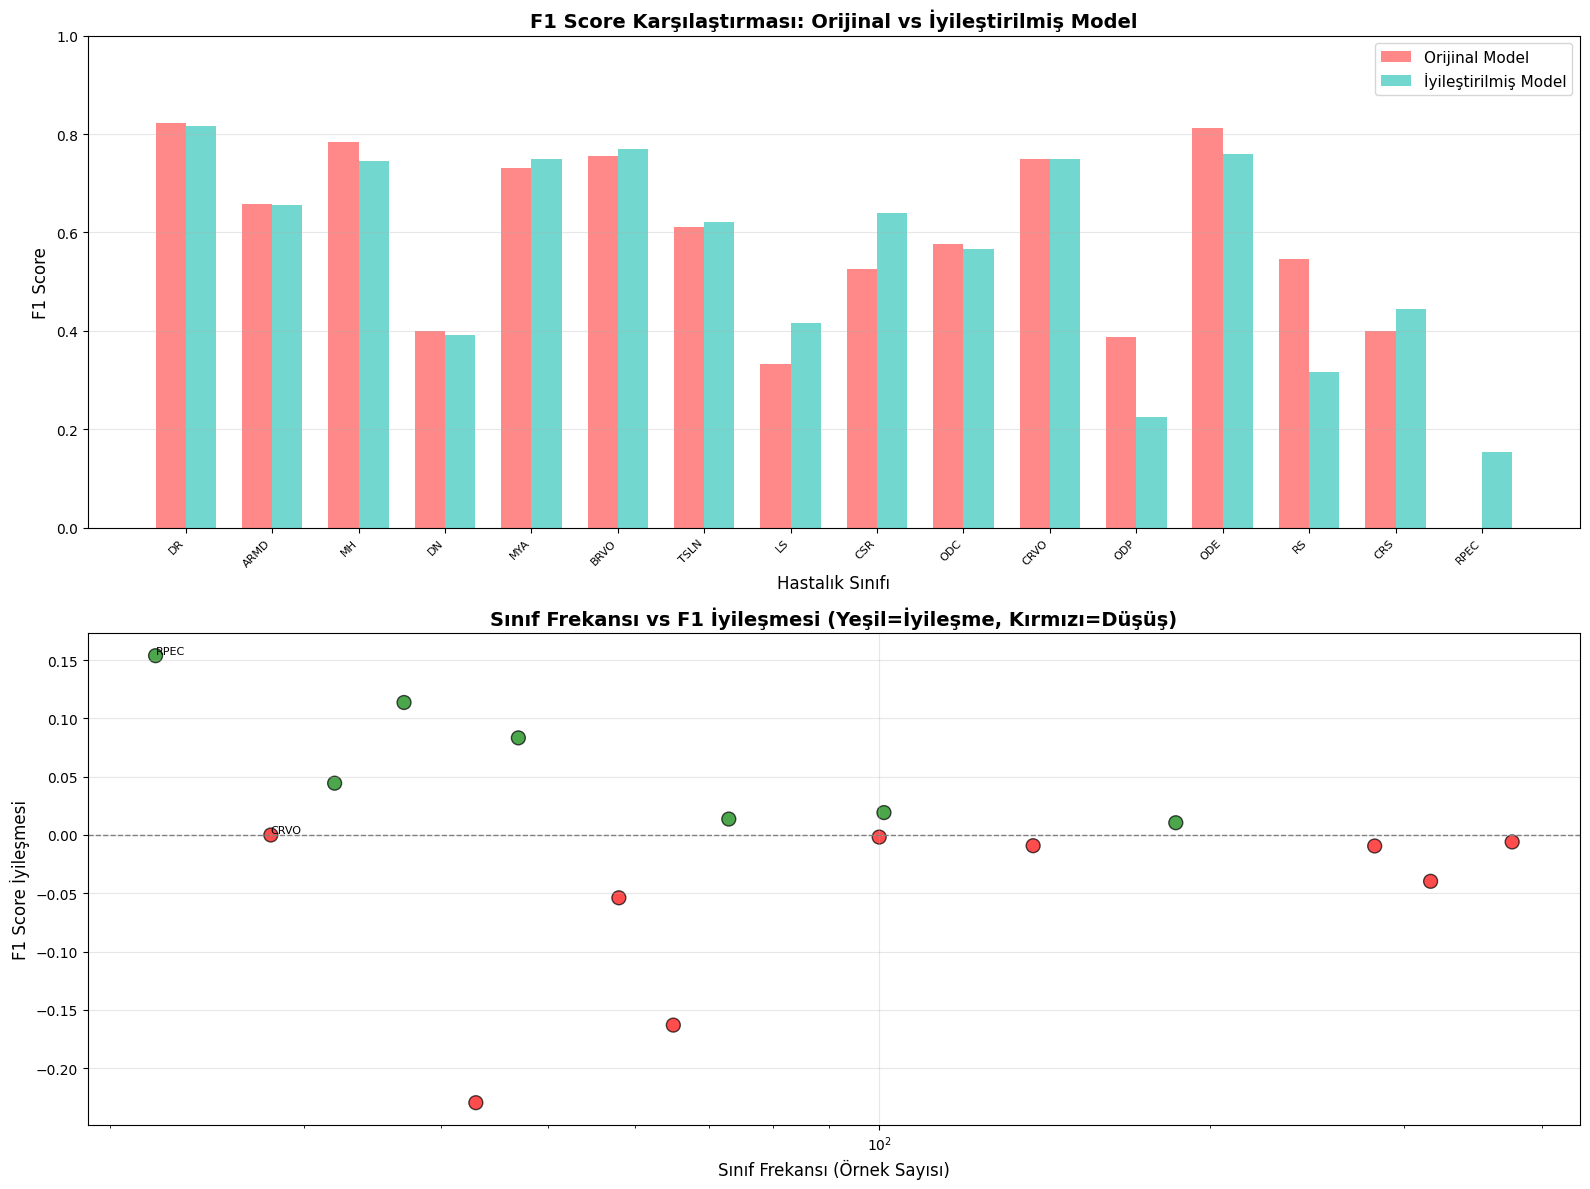


📊 Grafik 'model_comparison_imbalance_fix.png' olarak kaydedildi.


In [ ]:
import numpy as np

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

bar_width = 0.35
index = np.arange(OUT_FINAL)

# F1 Score karşılaştırması
ax1 = axes[0]
orig_f1 = test_result_fixed['f1'].numpy()
new_f1 = test_result_optimal['f1'].numpy()

bars1 = ax1.bar(index, orig_f1, bar_width, label='Orijinal Model', color='#FF6B6B', alpha=0.8)
bars2 = ax1.bar(index + bar_width, new_f1, bar_width, label='İyileştirilmiş Model', color='#4ECDC4', alpha=0.8)

ax1.set_xlabel('Hastalık Sınıfı', fontsize=12)
ax1.set_ylabel('F1 Score', fontsize=12)
ax1.set_title('F1 Score Karşılaştırması: Orijinal vs İyileştirilmiş Model', fontsize=14, fontweight='bold')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(label_cols, rotation=45, ha='right', fontsize=8)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 1)

# Class frequency vs F1 improvement
ax2 = axes[1]
class_freqs = pos_counts.values
f1_improvements = new_f1 - orig_f1

colors = ['green' if x > 0 else 'red' for x in f1_improvements]
scatter = ax2.scatter(class_freqs, f1_improvements, c=colors, s=100, alpha=0.7, edgecolors='black')

ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax2.set_xlabel('Sınıf Frekansı (Örnek Sayısı)', fontsize=12)
ax2.set_ylabel('F1 Score İyileşmesi', fontsize=12)
ax2.set_title('Sınıf Frekansı vs F1 İyileşmesi (Yeşil=İyileşme, Kırmızı=Düşüş)', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)

# Nadir sınıfları etiketle
for i, col in enumerate(label_cols):
    if class_freqs[i] < 30:  # Çok nadir sınıflar
        ax2.annotate(col, (class_freqs[i], f1_improvements[i]),
                    fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.savefig('images/model_comparison_imbalance_fix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Grafik 'images/model_comparison_imbalance_fix.png' olarak kaydedildi.")

In [109]:
# ==========================================
# 9. CONFUSION MATRIX - İYİLEŞTİRİLMİŞ MODEL
# ==========================================
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# İyileştirilmiş model için tahminleri topla
all_preds_v2 = []
all_labels_v2 = []

model_v2.eval()
with torch.no_grad():
    for x, y in tqdm(test_loader, desc='Collecting predictions (improved model)'):
        x = x.to(device)
        y_h = model_v2(x)
        y_h = torch.sigmoid(y_h)
        all_preds_v2.append(y_h.cpu())
        all_labels_v2.append(y.cpu())

all_preds_v2 = torch.cat(all_preds_v2, dim=0)
all_labels_v2 = torch.cat(all_labels_v2, dim=0)

# Binary predictions (threshold = 0.5)
all_preds_binary_v2 = (all_preds_v2 > 0.5).float()

print(f"✅ Test örnekleri: {len(all_preds_v2)}")
print(f"✅ Sınıf sayısı: {OUT_FINAL}")

✅ Test örnekleri: 640
✅ Sınıf sayısı: 16


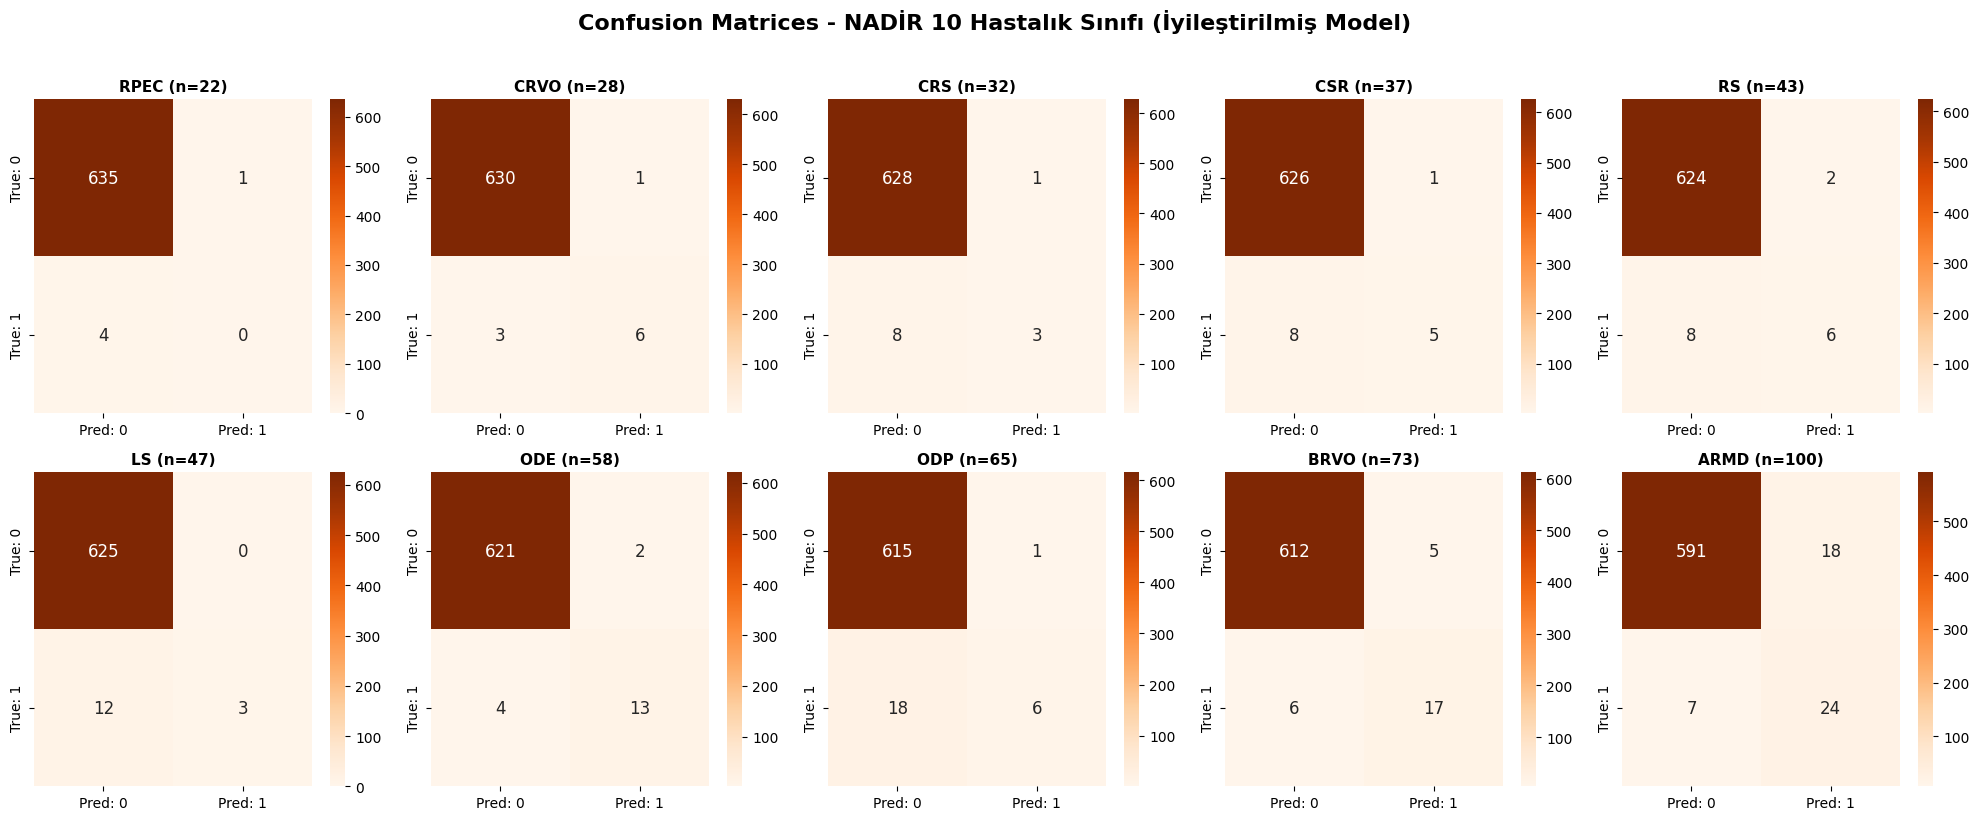


📊 Grafik 'confusion_matrices_rare_classes_v2.png' olarak kaydedildi.


In [ ]:
# ==========================================
# 10. CONFUSION MATRIX GRİD - NADİR SINIFLAR
# ==========================================
# En az örneği olan 10 sınıf için confusion matrix

# Sınıf frekanslarını al
class_counts = pos_counts.copy()

# En az örneği olan 10 sınıf
bottom_10_classes = class_counts.nsmallest(10).index.tolist()
bottom_10_indices = [list(label_cols).index(c) for c in bottom_10_classes]

# Multi-label confusion matrix hesapla
mcm_v2 = multilabel_confusion_matrix(all_labels_v2.numpy(), all_preds_binary_v2.numpy())

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (class_idx, class_name) in enumerate(zip(bottom_10_indices, bottom_10_classes)):
    cm = mcm_v2[class_idx]
    count = int(class_counts[class_name])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[idx],
                xticklabels=['Pred: 0', 'Pred: 1'],
                yticklabels=['True: 0', 'True: 1'],
                annot_kws={'size': 12})
    axes[idx].set_title(f'{class_name} (n={count})', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

plt.suptitle('Confusion Matrices - NADİR 10 Hastalık Sınıfı (İyileştirilmiş Model)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/confusion_matrices_rare_classes_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Grafik 'images/confusion_matrices_rare_classes_v2.png' olarak kaydedildi.")

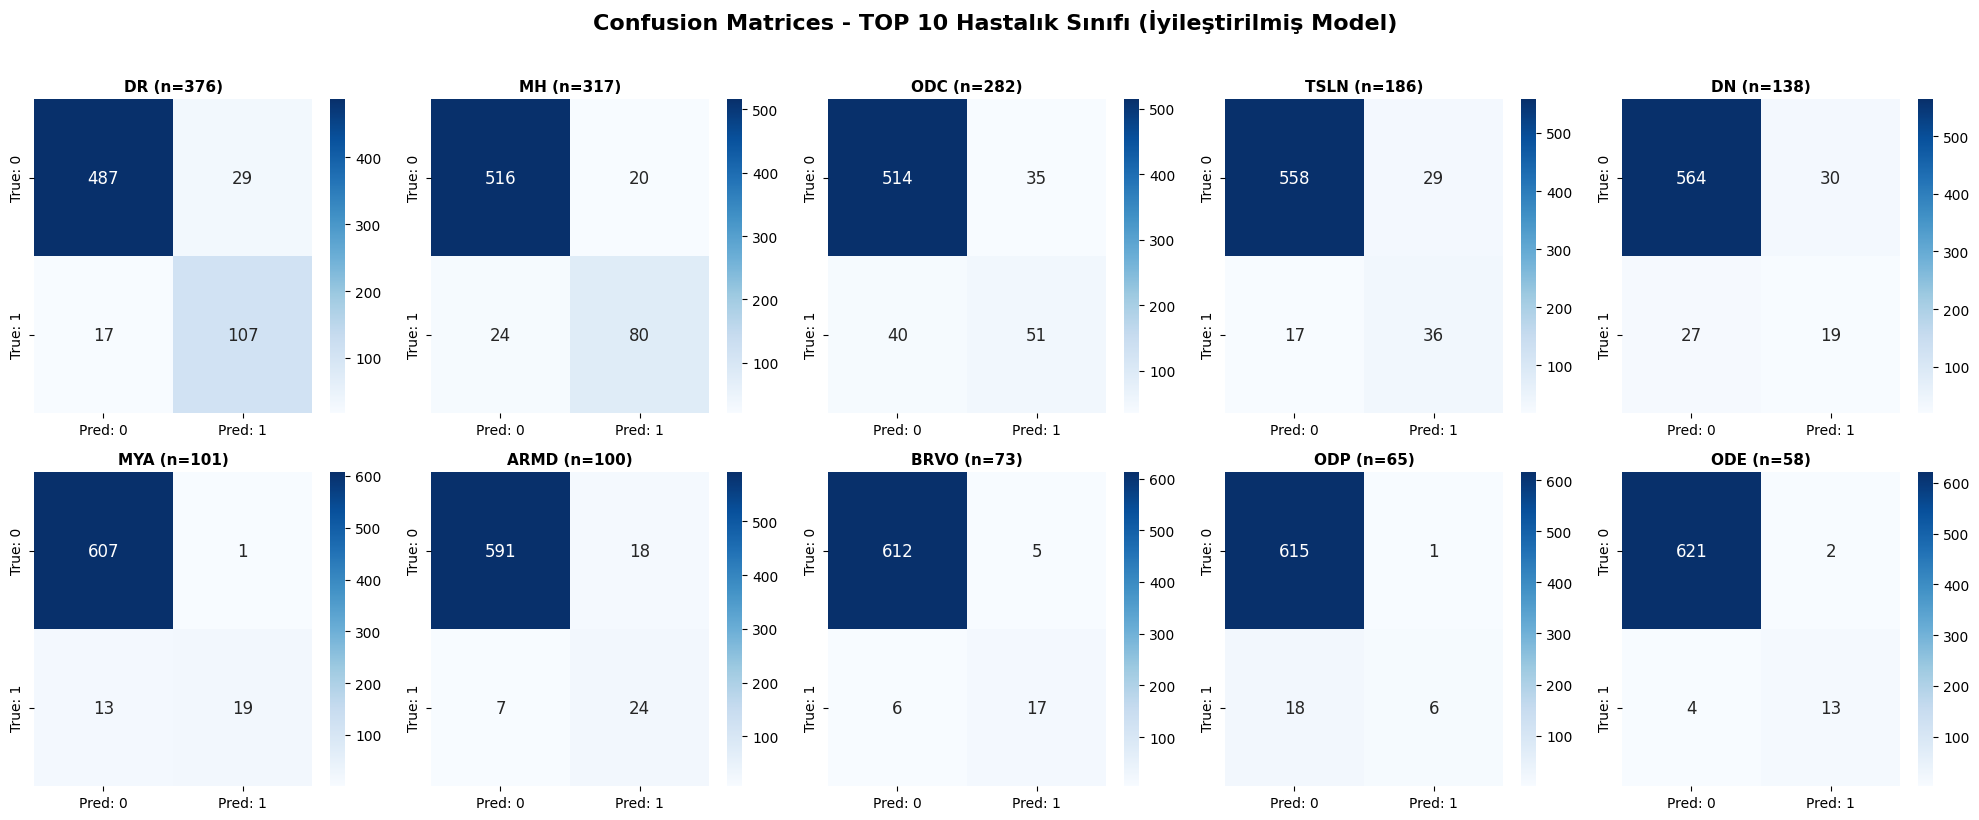


📊 Grafik 'confusion_matrices_top10_v2.png' olarak kaydedildi.


In [ ]:
# ==========================================
# 11. CONFUSION MATRIX GRİD - EN YAYGIN SINIFLAR
# ==========================================
# En çok örneği olan 10 sınıf için confusion matrix

top_10_classes = class_counts.nlargest(10).index.tolist()
top_10_indices = [list(label_cols).index(c) for c in top_10_classes]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (class_idx, class_name) in enumerate(zip(top_10_indices, top_10_classes)):
    cm = mcm_v2[class_idx]
    count = int(class_counts[class_name])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Pred: 0', 'Pred: 1'],
                yticklabels=['True: 0', 'True: 1'],
                annot_kws={'size': 12})
    axes[idx].set_title(f'{class_name} (n={count})', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

plt.suptitle('Confusion Matrices - TOP 10 Hastalık Sınıfı (İyileştirilmiş Model)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/confusion_matrices_top10_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Grafik 'images/confusion_matrices_top10_v2.png' olarak kaydedildi.")

In [112]:
# ==========================================
# 12. TÜM SINIFLARIN ÖZET CONFUSION MATRİX TABLOSU
# ==========================================
from tabulate import tabulate

# Her sınıf için TP, FP, FN, TN hesapla
summary_data = []

for i, class_name in enumerate(label_cols):
    cm = mcm_v2[i]
    tn, fp, fn, tp = cm.ravel()

    # Metrikler
    precision_i = tp / (tp + fp + 1e-10)
    recall_i = tp / (tp + fn + 1e-10)
    f1_i = 2 * precision_i * recall_i / (precision_i + recall_i + 1e-10)
    specificity_i = tn / (tn + fp + 1e-10)

    count = int(class_counts[class_name])

    summary_data.append({
        'Sınıf': class_name,
        'Örnek': count,
        'TP': int(tp),
        'FP': int(fp),
        'FN': int(fn),
        'TN': int(tn),
        'Precision': f'{precision_i:.3f}',
        'Recall': f'{recall_i:.3f}',
        'F1': f'{f1_i:.3f}',
        'Specificity': f'{specificity_i:.3f}'
    })

# DataFrame olarak göster
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Örnek', ascending=False)

print("=" * 100)
print("📊 TÜM SINIFLARIN CONFUSION MATRIX ÖZETİ (İyileştirilmiş Model)")
print("=" * 100)
print(summary_df.to_string(index=False))

# CSV olarak kaydet
summary_df.to_csv('confusion_matrix_summary_v2.csv', index=False)
print("\n✅ Özet tablo 'confusion_matrix_summary_v2.csv' olarak kaydedildi.")

📊 TÜM SINIFLARIN CONFUSION MATRIX ÖZETİ (İyileştirilmiş Model)
Sınıf  Örnek  TP  FP  FN  TN Precision Recall    F1 Specificity
   DR    376 107  29  17 487     0.787  0.863 0.823       0.944
   MH    317  80  20  24 516     0.800  0.769 0.784       0.963
  ODC    282  51  35  40 514     0.593  0.560 0.576       0.936
 TSLN    186  36  29  17 558     0.554  0.679 0.610       0.951
   DN    138  19  30  27 564     0.388  0.413 0.400       0.949
  MYA    101  19   1  13 607     0.950  0.594 0.731       0.998
 ARMD    100  24  18   7 591     0.571  0.774 0.658       0.970
 BRVO     73  17   5   6 612     0.773  0.739 0.756       0.992
  ODP     65   6   1  18 615     0.857  0.250 0.387       0.998
  ODE     58  13   2   4 621     0.867  0.765 0.812       0.997
   LS     47   3   0  12 625     1.000  0.200 0.333       1.000
   RS     43   6   2   8 624     0.750  0.429 0.545       0.997
  CSR     37   5   1   8 626     0.833  0.385 0.526       0.998
  CRS     32   3   1   8 628     0.750  0

We'll use precision, recall, and (macro) F1 score as our evaluation metrics

In [113]:
def accuracy(y_h, y):
    y_h = (y_h > 0.5).float()
    return (y_h == y).float().mean(dim=1).mean()

def train_epoch(model, loader, loss_fn, optimizer, device, epoch):
    model.train()
    lossi, acci = [], []

    for x, y in tqdm(loader, desc=f'Epoch {epoch}'):
        x, y = x.to(device), y.to(device)
        y_h = model(x)
        loss = loss_fn(y_h, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())

        y_h, y = y_h.detach().cpu(), y.detach().cpu()
        acc = accuracy(y_h, y)
        acci.append(acc)

    loss = torch.tensor(lossi).mean().item()
    acc = torch.tensor(acci).mean().item()
    return {'loss': loss, 'acc': acc}

def eval(model, loader, loss_fn, device):
    model.eval()
    lossi, acci = [], []

    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluation'):
            x, y = x.to(device), y.to(device)
            y_h = model(x)
            loss = loss_fn(y_h, y)
            lossi.append(loss.item())

            y_h, y = y_h.detach().cpu(), y.detach().cpu()
            acc = accuracy(y_h, y)
            acci.append(acc)

    loss = torch.tensor(lossi).mean().item()
    acc = torch.tensor(acci).mean().item()
    return {'loss': loss, 'acc': acc}

In [114]:
N_EPOCHS = 25
best_loss = float('inf')

train_resi, val_resi = [], []
BEST_MODEL = ''

no_improvement_count = 0
max_no_improvement = 3  # Set the threshold for consecutive epochs without improvement

for epoch in range(N_EPOCHS):
    train_res = train_epoch(model, train_loader, loss_fn, optimizer, device, epoch+1)
    val_res = eval(model, val_loader, loss_fn, device)

    print('- Train')
    print(f"  Loss: {train_res['loss']: 3.4f} | "
          f"Accuracy: {train_res['acc']: .3f}")

    print('- Validation')
    print(f"  Loss: {val_res['loss']: 3.4f} | "
          f"Accuracy: {val_res['acc']: .3f}")

    val_loss = val_res['loss']

    if val_loss < best_loss:
        best_loss = val_loss
        BEST_MODEL = f'convnext_cp_{epoch+1}.pth'
        torch.save(model.state_dict(), BEST_MODEL)
        print('* Current best loss. Saved model!')
        no_improvement_count = 0  # Reset the counter since there's an improvement
    else:
        no_improvement_count += 1

    if no_improvement_count >= max_no_improvement:
        print(f'No improvement in validation loss for {max_no_improvement} consecutive epochs. Stopping training.')
        break

    train_resi.append(train_res)
    val_resi.append(val_res)

Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


- Train
  Loss:  0.2053 | Accuracy:  0.941
- Validation
  Loss:  0.1499 | Accuracy:  0.950
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


- Train
  Loss:  0.1301 | Accuracy:  0.953
- Validation
  Loss:  0.1295 | Accuracy:  0.953
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


- Train
  Loss:  0.1043 | Accuracy:  0.961
- Validation
  Loss:  0.1178 | Accuracy:  0.957
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


- Train
  Loss:  0.0891 | Accuracy:  0.966
- Validation
  Loss:  0.1123 | Accuracy:  0.958
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


- Train
  Loss:  0.0735 | Accuracy:  0.972
- Validation
  Loss:  0.1085 | Accuracy:  0.961
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.20s/it]


- Train
  Loss:  0.0654 | Accuracy:  0.973
- Validation
  Loss:  0.1058 | Accuracy:  0.963
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


- Train
  Loss:  0.0537 | Accuracy:  0.978
- Validation
  Loss:  0.1032 | Accuracy:  0.963
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


- Train
  Loss:  0.0464 | Accuracy:  0.982
- Validation
  Loss:  0.1113 | Accuracy:  0.963


Evaluation: 100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


- Train
  Loss:  0.0413 | Accuracy:  0.983
- Validation
  Loss:  0.1107 | Accuracy:  0.963


Evaluation: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]

- Train
  Loss:  0.0319 | Accuracy:  0.988
- Validation
  Loss:  0.1150 | Accuracy:  0.964
No improvement in validation loss for 3 consecutive epochs. Stopping training.


# Model evaluation

In [115]:
model.load_state_dict(torch.load(BEST_MODEL))

<All keys matched successfully>

In [116]:
import json

SAVE_RES = {
    'train': train_resi,
    'val': val_resi
}

with open('convnext_retina_result.json', 'w') as f:
    json.dump(SAVE_RES, f)

In [117]:
def true_positive(y_pred, y_true, th=0.5):
    assert y_pred.shape == y_true.shape
    y_pred = (y_pred > th).float()
    true_positive = torch.sum((y_pred == 1) & (y_true == 1), dim=0)
    return true_positive

def false_positive(y_pred, y_true, th=0.5):
    assert y_pred.shape == y_true.shape
    y_pred = (y_pred > th).float()
    false_positive = torch.sum((y_pred == 1) & (y_true == 0), dim=0)
    return false_positive

def false_negative(y_pred, y_true, th=0.5):
    assert y_pred.shape == y_true.shape
    y_pred = (y_pred > th).float()
    false_negative = torch.sum((y_pred == 0) & (y_true == 1), dim=0)
    return false_negative

In [118]:
# test function correctness
y_true = torch.tensor([[0,1,1,0], [0,1,0,1]])
y_pred = torch.tensor([[0,1,0,1], [1,0,0,1]])

print('True positive:', true_positive(y_pred, y_true))
print('False positive:', false_positive(y_pred, y_true))
print('False negative:', false_negative(y_pred, y_true))

True positive: tensor([0, 1, 0, 1])
False positive: tensor([1, 0, 0, 1])
False negative: tensor([0, 1, 1, 0])


For our model result, we would want a high recall and a good precision as as missed diagnosis is bad while a wrong prediction might not be so life-threatening

In [119]:
true_pos, false_pos, false_neg = torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL)

model.eval()
with torch.no_grad():
    for x, y in tqdm(val_loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        y_h = model(x)
        y_h, y = y_h.detach().cpu(), y.detach().cpu()

        tp = true_positive(y_h, y)
        fp = false_positive(y_h, y)
        fn = false_negative(y_h, y)

        true_pos += tp; false_pos += fp; false_neg += fn

Evaluation: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


In [120]:
precision = true_pos / (true_pos + false_pos + 1e-10)
precision

tensor([0.8430, 0.7368, 0.7957, 0.4688, 0.8519, 0.9167, 0.7879, 0.9091, 1.0000,
        0.8000, 1.0000, 0.5000, 0.7368, 1.0000, 1.0000, 0.0000])

In [121]:
recall = true_pos / (true_pos + false_neg + 1e-10)
recall

tensor([0.7727, 0.3684, 0.7255, 0.3261, 0.6765, 0.4783, 0.4000, 0.5882, 0.0909,
        0.4444, 0.6250, 0.0769, 0.6667, 0.7143, 0.0909, 0.0000])

In [122]:
f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
f1

tensor([0.8063, 0.4912, 0.7590, 0.3846, 0.7541, 0.6286, 0.5306, 0.7143, 0.1667,
        0.5714, 0.7692, 0.1333, 0.7000, 0.8333, 0.1667, 0.0000])

# Final evaluation on the test set

In [123]:
def eval3(model, loader, device):
    true_pos, false_pos, false_neg = torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL)

    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluation on 3 metrics'):
            x, y = x.to(device), y.to(device)
            y_h = model(x)
            y_h, y = y_h.detach().cpu(), y.detach().cpu()

            tp = true_positive(y_h, y)
            fp = false_positive(y_h, y)
            fn = false_negative(y_h, y)

            true_pos += tp; false_pos += fp; false_neg += fn

    precision = true_pos / (true_pos + false_pos + 1e-10)
    recall = true_pos / (true_pos + false_neg + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    return {
        'precision': precision, 'recall': recall, 'f1': f1
    }

test_result = eval3(model, test_loader, device)

Evaluation on 3 metrics: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


In [124]:
test_result['precision']

tensor([0.9048, 0.8889, 0.7885, 0.6207, 0.8750, 0.8235, 0.7692, 0.7000, 1.0000,
        0.8095, 0.8571, 0.4167, 0.8125, 1.0000, 1.0000, 0.0000])

In [125]:
test_result['recall']

tensor([0.7661, 0.5161, 0.7885, 0.3913, 0.6562, 0.6087, 0.3774, 0.4667, 0.3077,
        0.3736, 0.6667, 0.2083, 0.7647, 0.3571, 0.1818, 0.0000])

In [126]:
test_result['f1']

tensor([0.8297, 0.6531, 0.7885, 0.4800, 0.7500, 0.7000, 0.5063, 0.5600, 0.4706,
        0.5113, 0.7500, 0.2778, 0.7879, 0.5263, 0.3077, 0.0000])

In [127]:
test_res = eval(model, test_loader, loss_fn, device)

Evaluation: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


In [128]:
print('- Test')
print(f"  Loss: {test_res['loss']: 3.4f} | "
      f"Accuracy: {test_res['acc']: .3f}")

- Test
  Loss:  0.0950 | Accuracy:  0.966


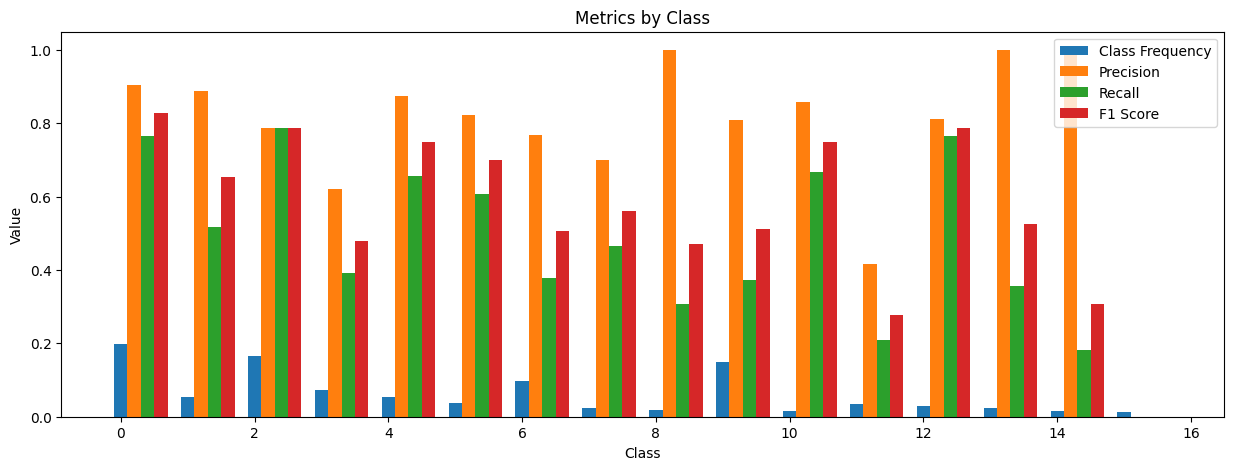

In [ ]:
bar_width = 0.2
index = np.arange(OUT_FINAL)
classes_count = classes_freq
classes_prob = classes_count / classes_count.sum()
classes_prob = classes_prob[::-1]

# Plotting the bars
plt.figure(figsize=(15,5))
plt.bar(index, classes_prob, width=bar_width, label='Class Frequency')
plt.bar(index + 1 * bar_width, test_result['precision'], width=bar_width, label='Precision')
plt.bar(index + 2 * bar_width, test_result['recall'], width=bar_width, label='Recall')
plt.bar(index + 3 * bar_width, test_result['f1'], width=bar_width, label='F1 Score')

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Value')
plt.title('Metrics by Class')
plt.legend()

plt.savefig('images/metrics_by_class.png', dpi=300, bbox_inches='tight')plt.show()

From the chart, we can see that when the amount of data is decent the model performs prety well around 70% in F1 score. However, when the amount of data is small, there are two cases. The first one is that the model can still perform pertty well but Recall is far lower than Precision. The second case is that the model doens't learn about these classes at all. This problem welcomes further investigation. That's it for now, thank you!

# 📊 Model Performans Görselleştirmeleri (Sunum için)

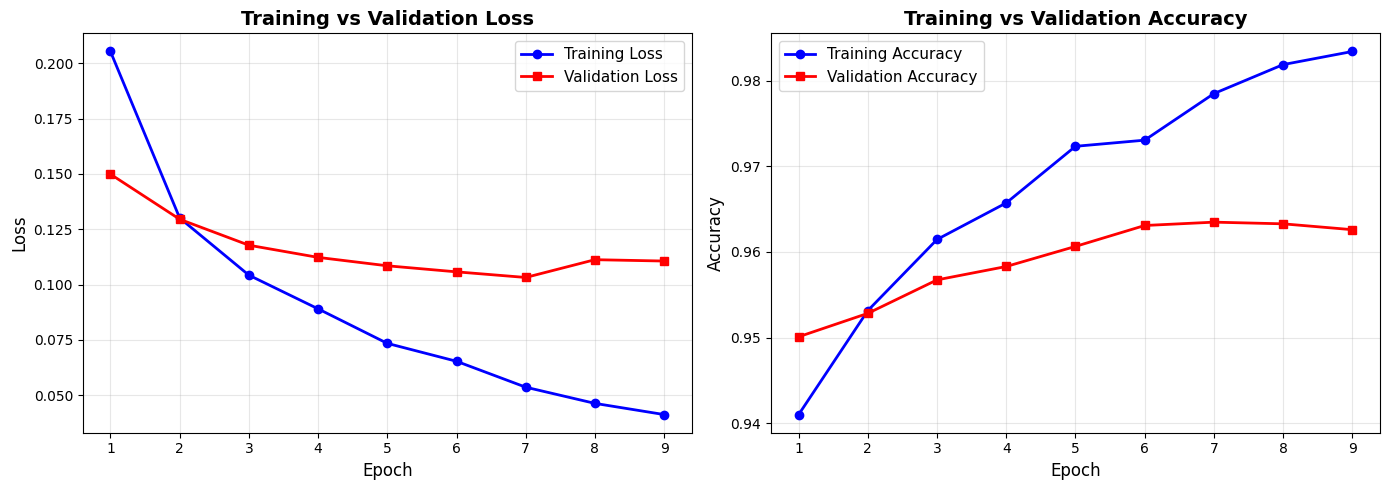

In [ ]:
# 1. Training & Validation Loss/Accuracy Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
train_losses = [r['loss'] for r in train_resi]
val_losses = [r['loss'] for r in val_resi]
epochs = range(1, len(train_losses) + 1)

axes[0].plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curve
train_accs = [r['acc'] for r in train_resi]
val_accs = [r['acc'] for r in val_resi]

axes[1].plot(epochs, train_accs, 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs, val_accs, 'r-s', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [131]:
# 2. Multi-Label Confusion Matrix (Per-Class Binary Confusion)
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# Tüm tahminleri ve gerçek değerleri topla
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in tqdm(test_loader, desc='Collecting predictions'):
        x = x.to(device)
        y_h = model(x)
        y_h = torch.sigmoid(y_h)  # Sigmoid uygula
        all_preds.append(y_h.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Binary predictions (threshold = 0.5)
all_preds_binary = (all_preds > 0.5).float()

# Sınıf isimleri (CSV zaten temizlenmiş, sadece ID ve Disease_Risk çıkar)
class_names = train_label_df.drop(columns=['ID', 'Disease_Risk']).columns.tolist()

print(f"Total test samples: {len(all_preds)}")
print(f"Number of classes: {len(class_names)}")

Total test samples: 640
Number of classes: 16


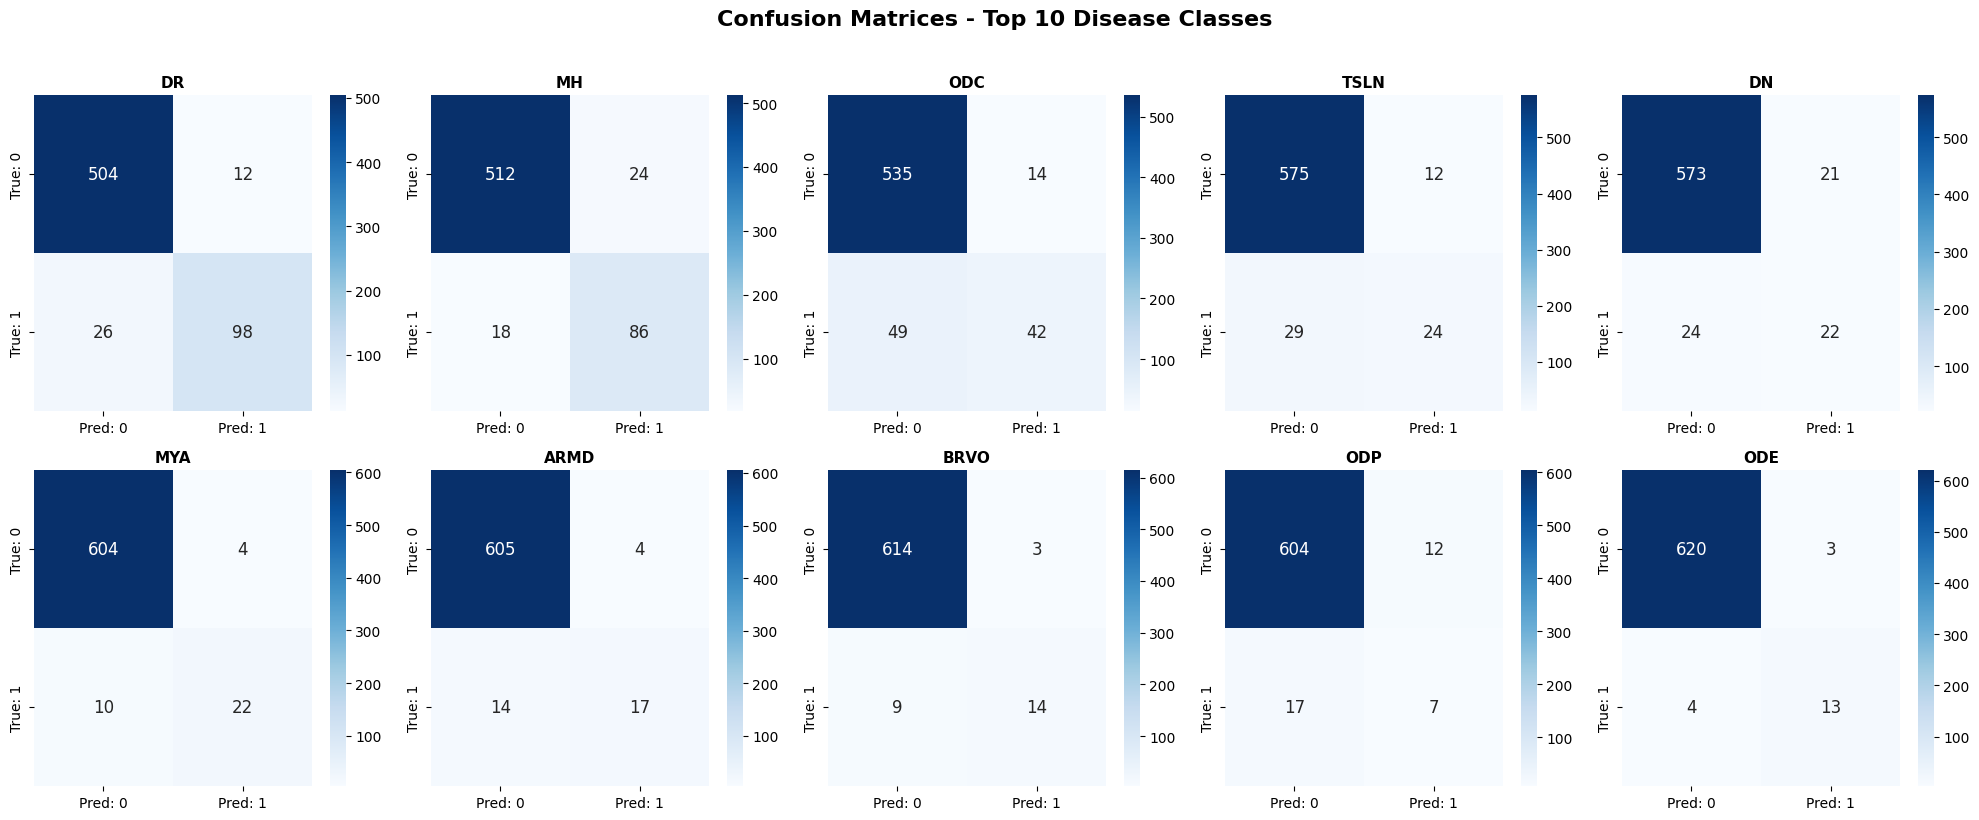

In [ ]:
# 3. Top-10 Hastalık Sınıfları için Confusion Matrix Grid
# En çok örneği olan 10 hastalığı seç
class_counts = train_label_df.drop(columns=['ID', 'Disease_Risk']).sum()
top_10_classes = class_counts.nlargest(10).index.tolist()
top_10_indices = [class_names.index(c) for c in top_10_classes]

# Multi-label confusion matrix hesapla
mcm = multilabel_confusion_matrix(all_labels.numpy(), all_preds_binary.numpy())

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (class_idx, class_name) in enumerate(zip(top_10_indices, top_10_classes)):
    cm = mcm[class_idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Pred: 0', 'Pred: 1'],
                yticklabels=['True: 0', 'True: 1'],
                annot_kws={'size': 12})
    axes[idx].set_title(f'{class_name}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

plt.suptitle('Confusion Matrices - Top 10 Disease Classes', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/confusion_matrices_top10.png', dpi=300, bbox_inches='tight')
plt.show()

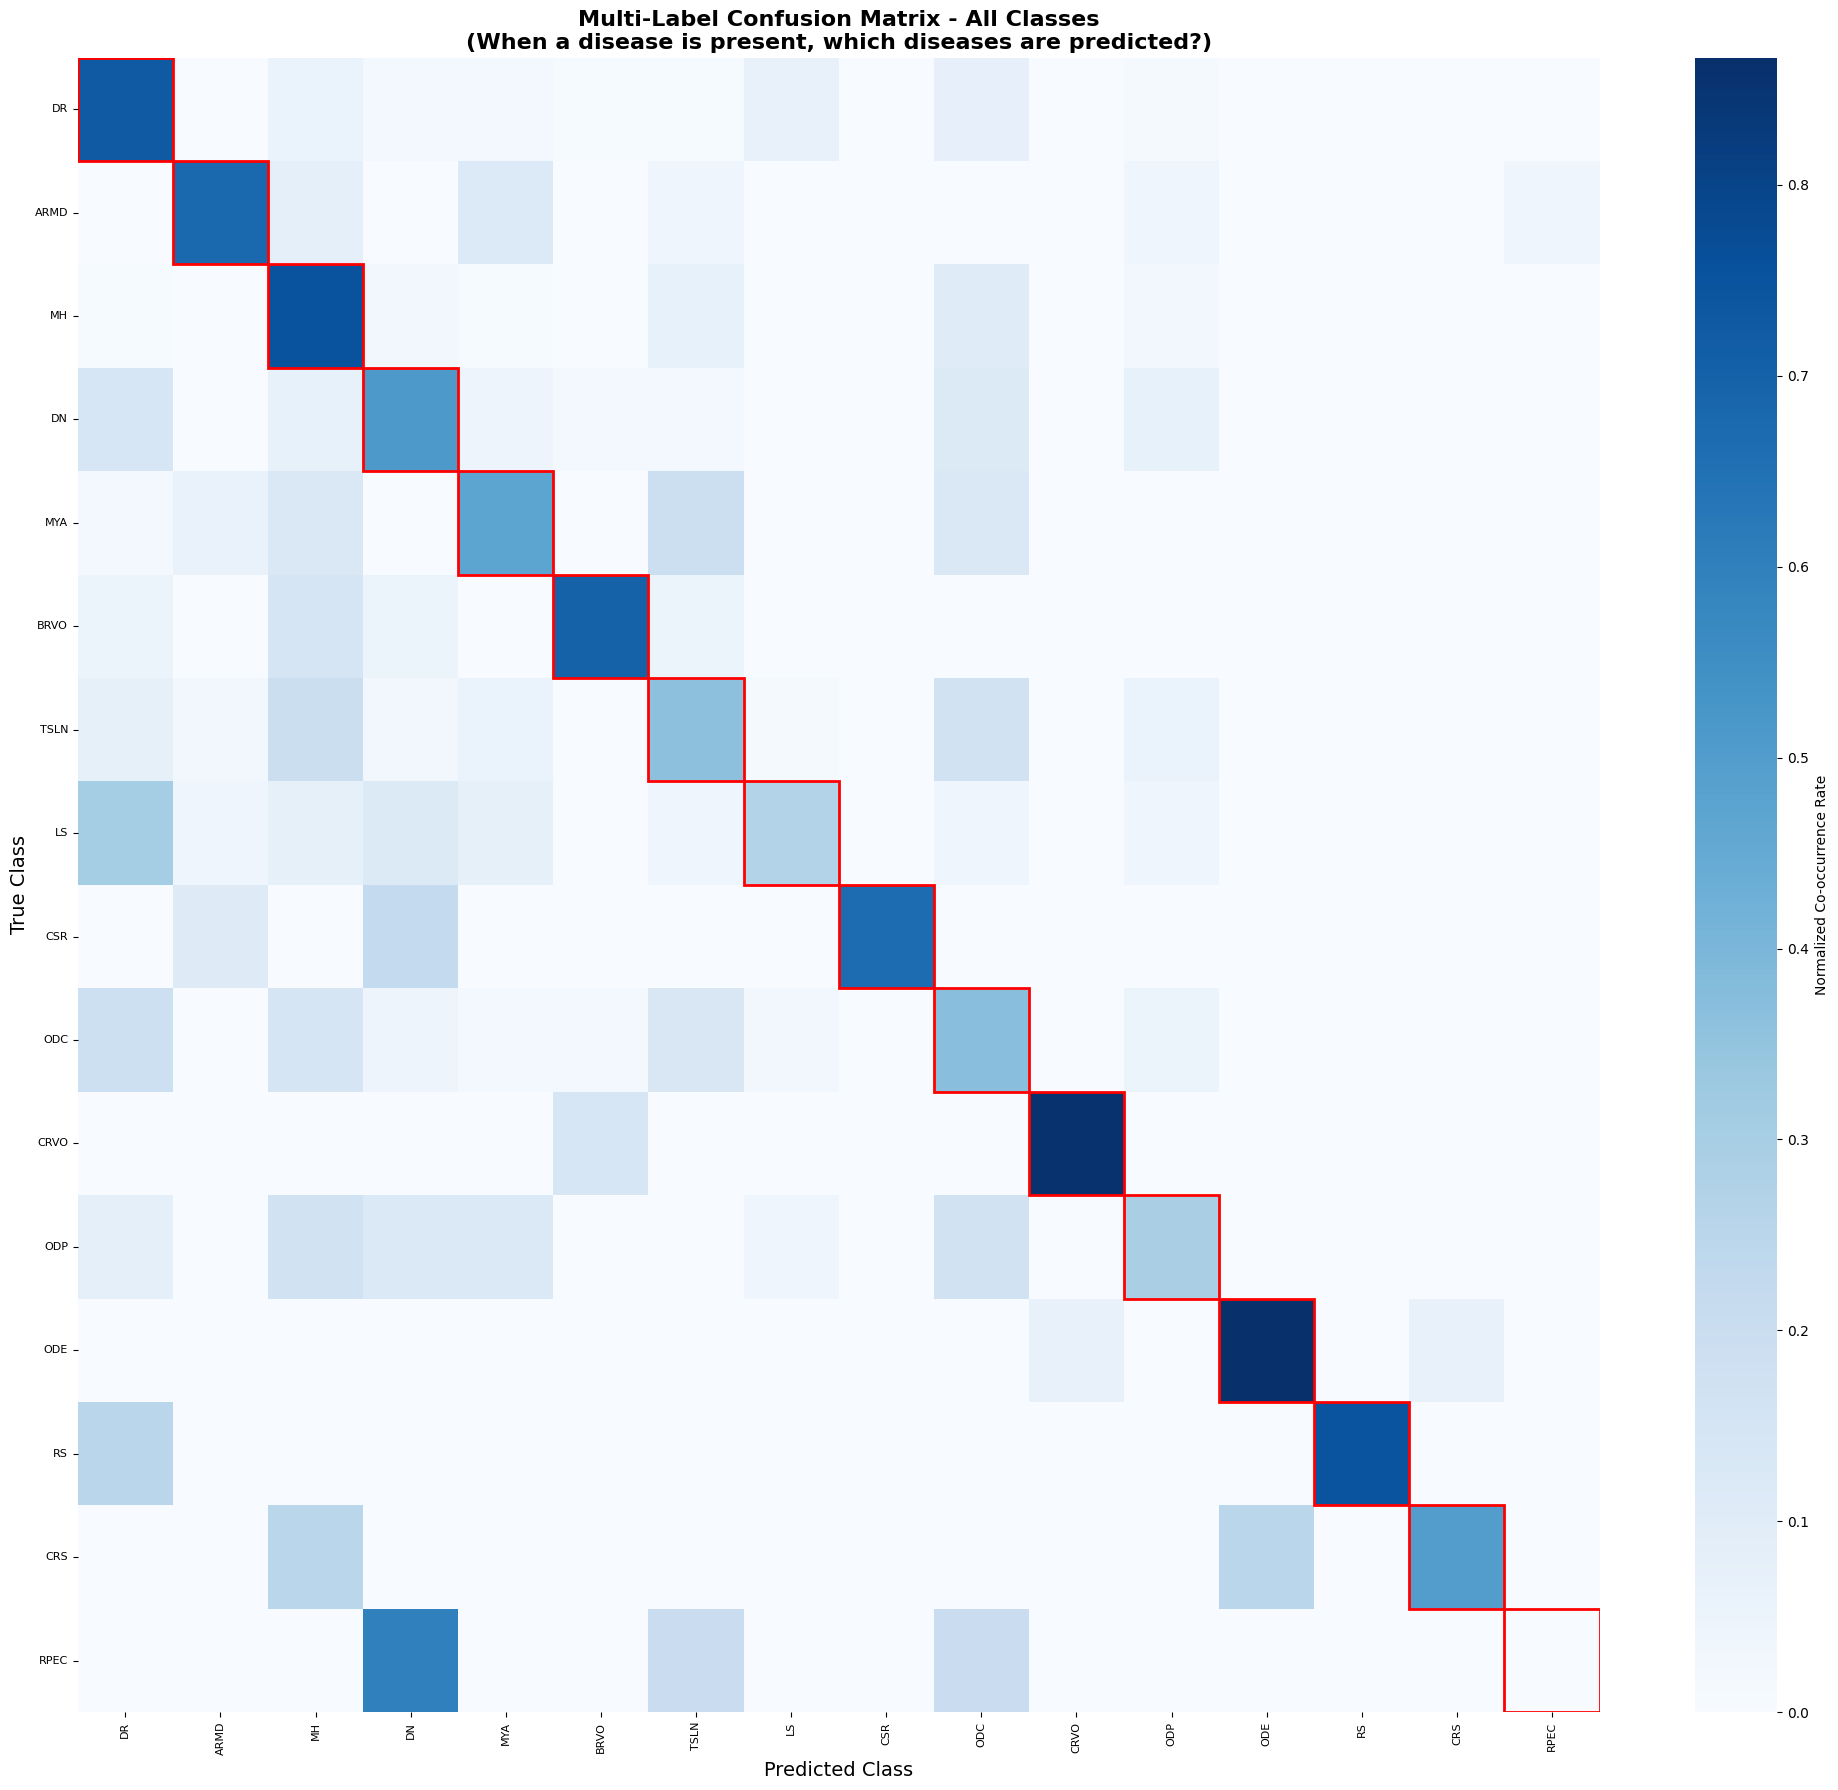


Diagonal Accuracy (Her sınıfın kendini doğru tahmin etme oranı):
  DR: 0.726
  ARMD: 0.680
  MH: 0.754
  DN: 0.512
  MYA: 0.468
  BRVO: 0.700
  TSLN: 0.364
  LS: 0.269
  CSR: 0.667
  ODC: 0.372
  CRVO: 0.857
  ODP: 0.292
  ODE: 0.867
  RS: 0.750
  CRS: 0.500
  RPEC: 0.000


In [ ]:
# 3.1 TÜM SINIFLAR İÇİN TEK BÜYÜK CONFUSION MATRIX
# Multi-label için her sınıfın TP, FP, FN, TN değerlerini birleştirerek gösterim

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Her sınıf için TP, TN, FP, FN hesapla
num_classes = len(class_names)
all_labels_np = all_labels.numpy()
all_preds_np = all_preds_binary.numpy()

# Confusion matrix: Her sınıf için tahmin vs gerçek değer
# Satırlar: Gerçek değer, Sütunlar: Tahmin edilen değer
# Bu multi-label olduğu için, her örnek için hangi sınıfların aktif olduğunu gösteriyoruz

# Sınıflar arası korelasyon matrisi oluştur (gerçek vs tahmin)
confusion_all = np.zeros((num_classes, num_classes))

# Her örnek için, gerçek pozitif sınıfların tahmin edilip edilmediğini kontrol et
for i in range(len(all_labels_np)):
    true_classes = np.where(all_labels_np[i] == 1)[0]
    pred_classes = np.where(all_preds_np[i] == 1)[0]

    for true_c in true_classes:
        for pred_c in pred_classes:
            confusion_all[true_c, pred_c] += 1

# Normalize et (satır bazında - her gerçek sınıf için)
row_sums = confusion_all.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # Sıfıra bölmeyi önle
confusion_normalized = confusion_all / row_sums

# Büyük figür oluştur
fig, ax = plt.subplots(figsize=(20, 18))

# Heatmap çiz
sns.heatmap(confusion_normalized,
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues',
            annot=False,  # Çok fazla sınıf var, sayıları gösterme
            fmt='.2f',
            ax=ax,
            cbar_kws={'label': 'Normalized Co-occurrence Rate'})

# Diagonal değerleri vurgula (doğru tahminler)
for i in range(num_classes):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

ax.set_xlabel('Predicted Class', fontsize=14)
ax.set_ylabel('True Class', fontsize=14)
ax.set_title('Multi-Label Confusion Matrix - All Classes\n(When a disease is present, which diseases are predicted?)',
             fontsize=16, fontweight='bold')

plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('images/confusion_matrix_all_classes.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nDiagonal Accuracy (Her sınıfın kendini doğru tahmin etme oranı):")
for i, name in enumerate(class_names):
    diag_acc = confusion_normalized[i, i] if row_sums[i, 0] > 0 else 0
    print(f"  {name}: {diag_acc:.3f}")

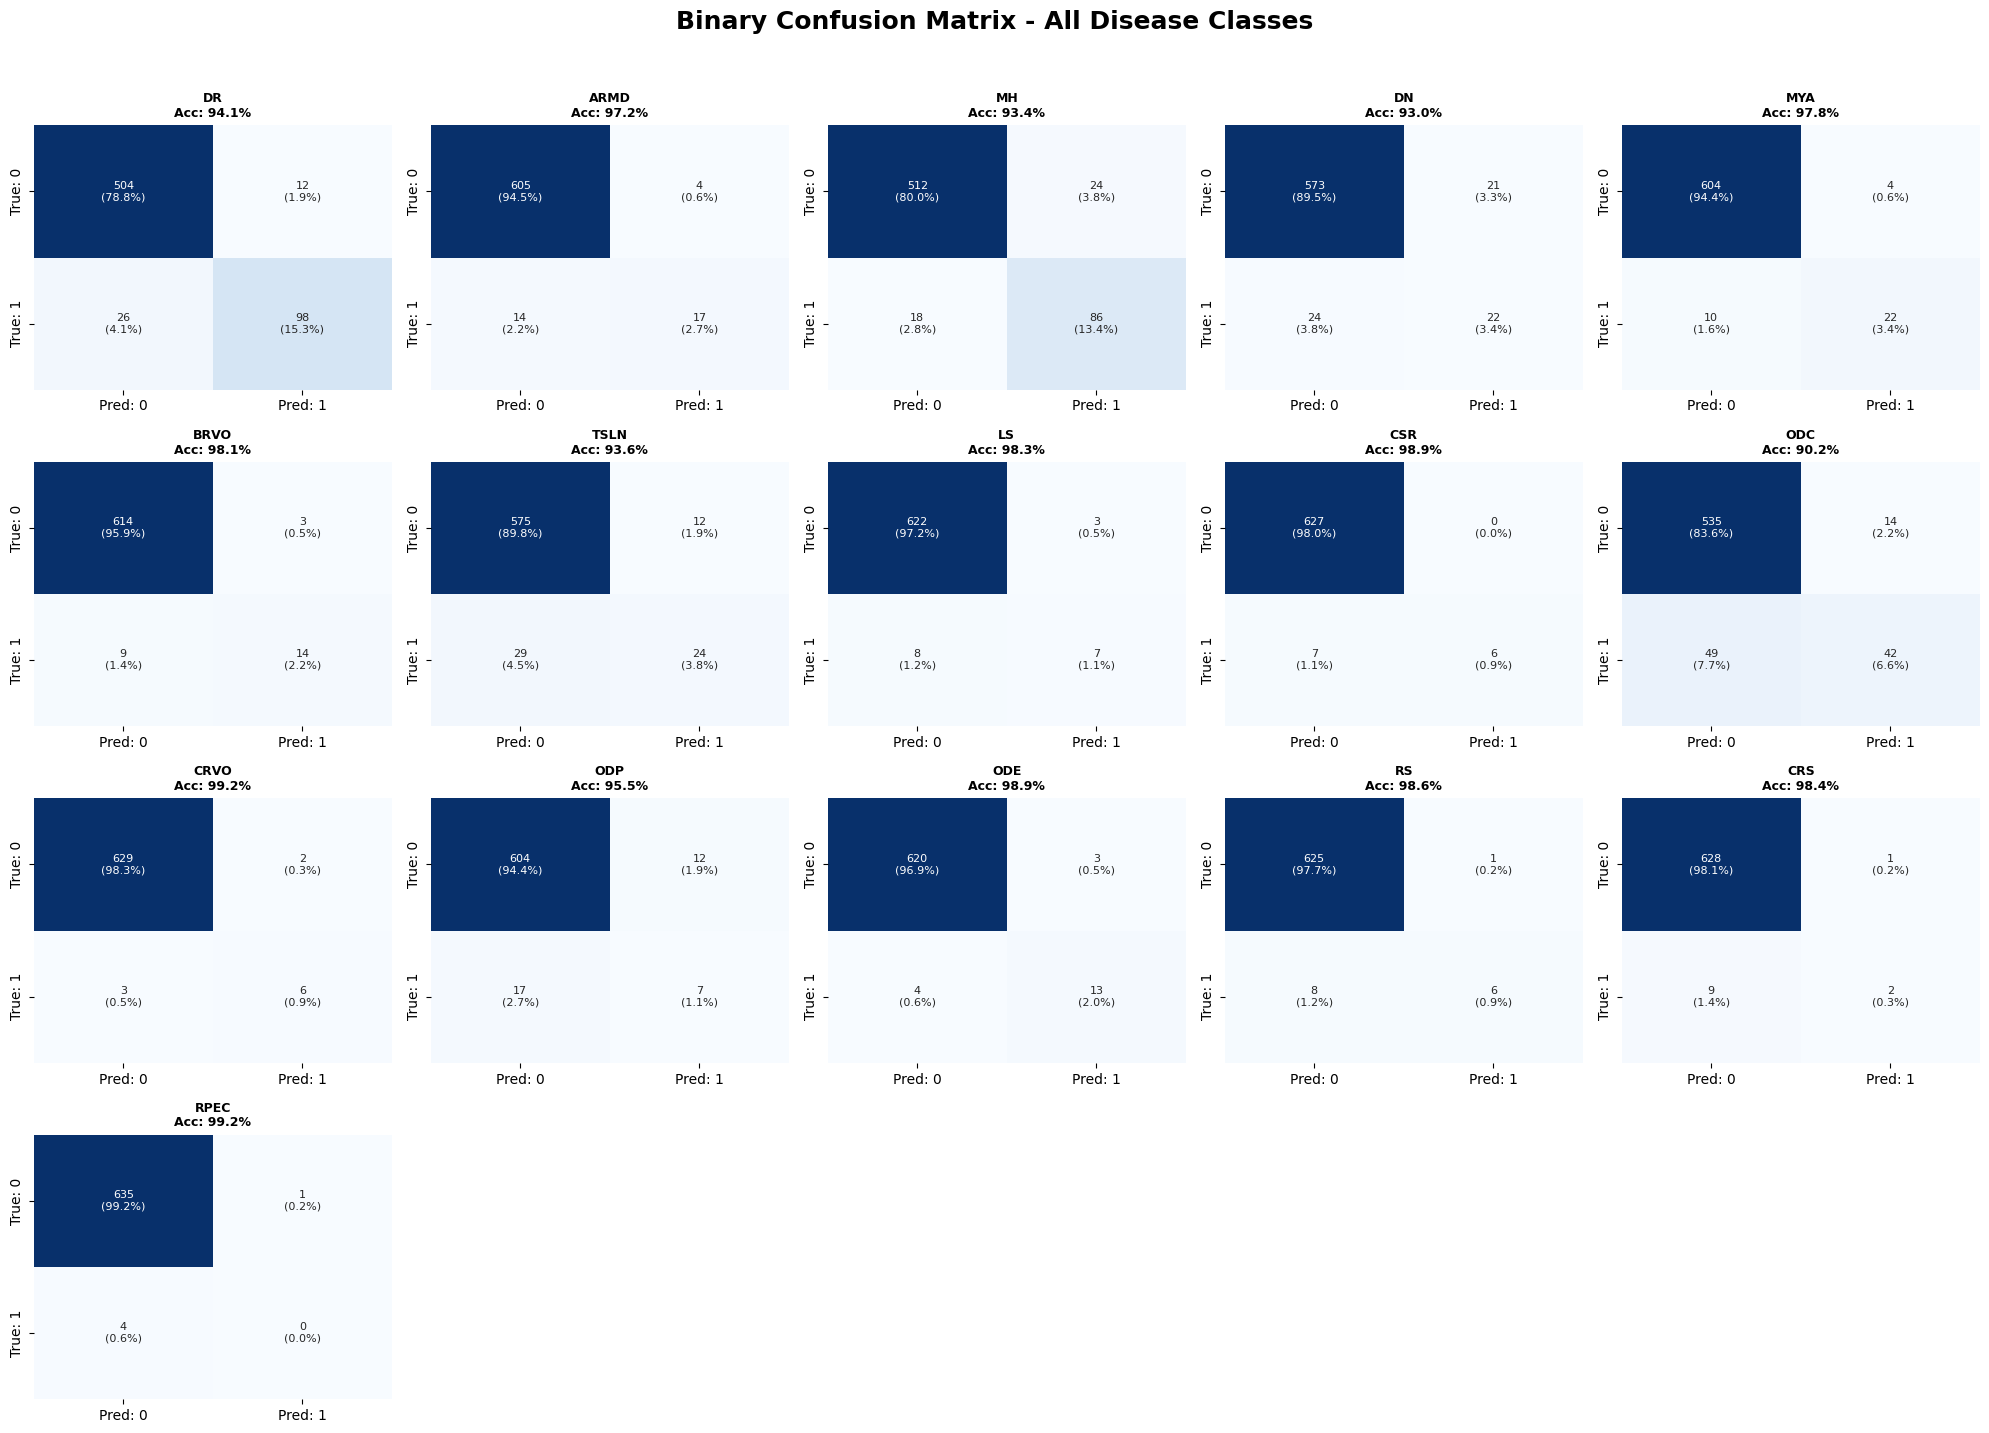


ÖZET İSTATİSTİKLER
DR                             | TP:   98 | TN:  504 | FP:   12 | FN:   26 | Precision: 0.891 | Recall: 0.790 | F1: 0.838
ARMD                           | TP:   17 | TN:  605 | FP:    4 | FN:   14 | Precision: 0.810 | Recall: 0.548 | F1: 0.654
MH                             | TP:   86 | TN:  512 | FP:   24 | FN:   18 | Precision: 0.782 | Recall: 0.827 | F1: 0.804
DN                             | TP:   22 | TN:  573 | FP:   21 | FN:   24 | Precision: 0.512 | Recall: 0.478 | F1: 0.494
MYA                            | TP:   22 | TN:  604 | FP:    4 | FN:   10 | Precision: 0.846 | Recall: 0.688 | F1: 0.759
BRVO                           | TP:   14 | TN:  614 | FP:    3 | FN:    9 | Precision: 0.824 | Recall: 0.609 | F1: 0.700
TSLN                           | TP:   24 | TN:  575 | FP:   12 | FN:   29 | Precision: 0.667 | Recall: 0.453 | F1: 0.539
LS                             | TP:    7 | TN:  622 | FP:    3 | FN:    8 | Precision: 0.700 | Recall: 0.467 | F1: 0.560
CSR 

In [ ]:
# 3.2 TÜM SINIFLAR İÇİN GRID CONFUSION MATRIX
# Her sınıfın binary confusion matrix'ini tek grafikte göster

from sklearn.metrics import multilabel_confusion_matrix

# Multi-label confusion matrix hesapla
mcm = multilabel_confusion_matrix(all_labels.numpy(), all_preds_binary.numpy())

# Grid boyutunu hesapla
num_classes = len(class_names)
cols = 5
rows = int(np.ceil(num_classes / cols))

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()

for idx in range(num_classes):
    cm = mcm[idx]
    # TN, FP, FN, TP değerlerini al
    tn, fp, fn, tp = cm.ravel()

    # Normalize confusion matrix (yüzde olarak)
    cm_normalized = cm.astype('float') / cm.sum() * 100

    # Annotation text oluştur (hem sayı hem yüzde)
    annot_text = np.array([[f'{tn}\n({cm_normalized[0,0]:.1f}%)', f'{fp}\n({cm_normalized[0,1]:.1f}%)'],
                           [f'{fn}\n({cm_normalized[1,0]:.1f}%)', f'{tp}\n({cm_normalized[1,1]:.1f}%)']])

    sns.heatmap(cm, annot=annot_text, fmt='', cmap='Blues', ax=axes[idx],
                xticklabels=['Pred: 0', 'Pred: 1'],
                yticklabels=['True: 0', 'True: 1'],
                annot_kws={'size': 8},
                cbar=False)

    # Accuracy hesapla
    accuracy = (tp + tn) / (tp + tn + fp + fn) * 100
    axes[idx].set_title(f'{class_names[idx]}\nAcc: {accuracy:.1f}%', fontsize=9, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

# Boş subplot'ları gizle
for idx in range(num_classes, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Binary Confusion Matrix - All Disease Classes', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/confusion_matrices_all_classes_grid.png', dpi=300, bbox_inches='tight')
plt.show()

# Özet istatistikler
print("\n" + "="*60)
print("ÖZET İSTATİSTİKLER")
print("="*60)
for idx, name in enumerate(class_names):
    cm = mcm[idx]
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"{name:30s} | TP: {tp:4d} | TN: {tn:4d} | FP: {fp:4d} | FN: {fn:4d} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")

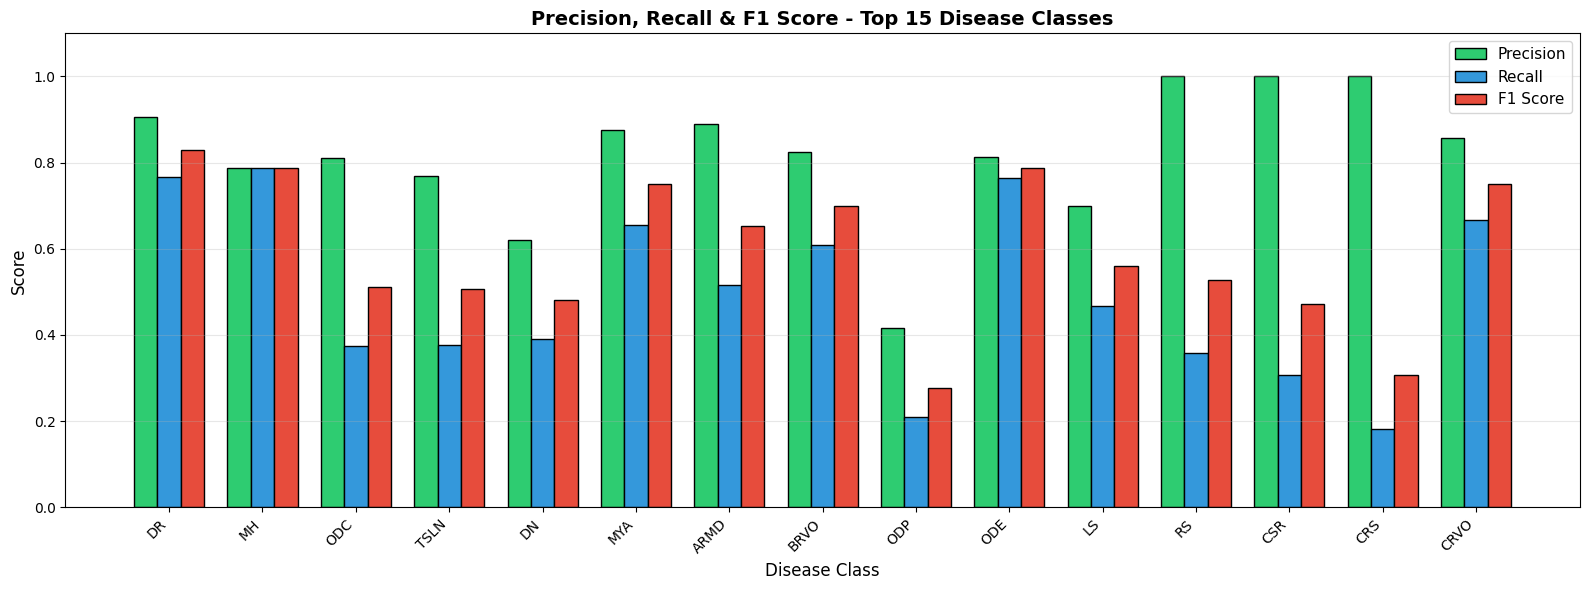

In [ ]:
# 4. Precision, Recall, F1 Score Bar Chart (Top 15 sınıflar)
top_15_classes = class_counts.nlargest(15).index.tolist()
top_15_indices = [class_names.index(c) for c in top_15_classes]

precision_top15 = test_result['precision'][top_15_indices].numpy()
recall_top15 = test_result['recall'][top_15_indices].numpy()
f1_top15 = test_result['f1'][top_15_indices].numpy()

x = np.arange(len(top_15_classes))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6))
bars1 = ax.bar(x - width, precision_top15, width, label='Precision', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x, recall_top15, width, label='Recall', color='#3498db', edgecolor='black')
bars3 = ax.bar(x + width, f1_top15, width, label='F1 Score', color='#e74c3c', edgecolor='black')

ax.set_xlabel('Disease Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision, Recall & F1 Score - Top 15 Disease Classes', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_15_classes, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('images/precision_recall_f1_top15.png', dpi=300, bbox_inches='tight')
plt.show()

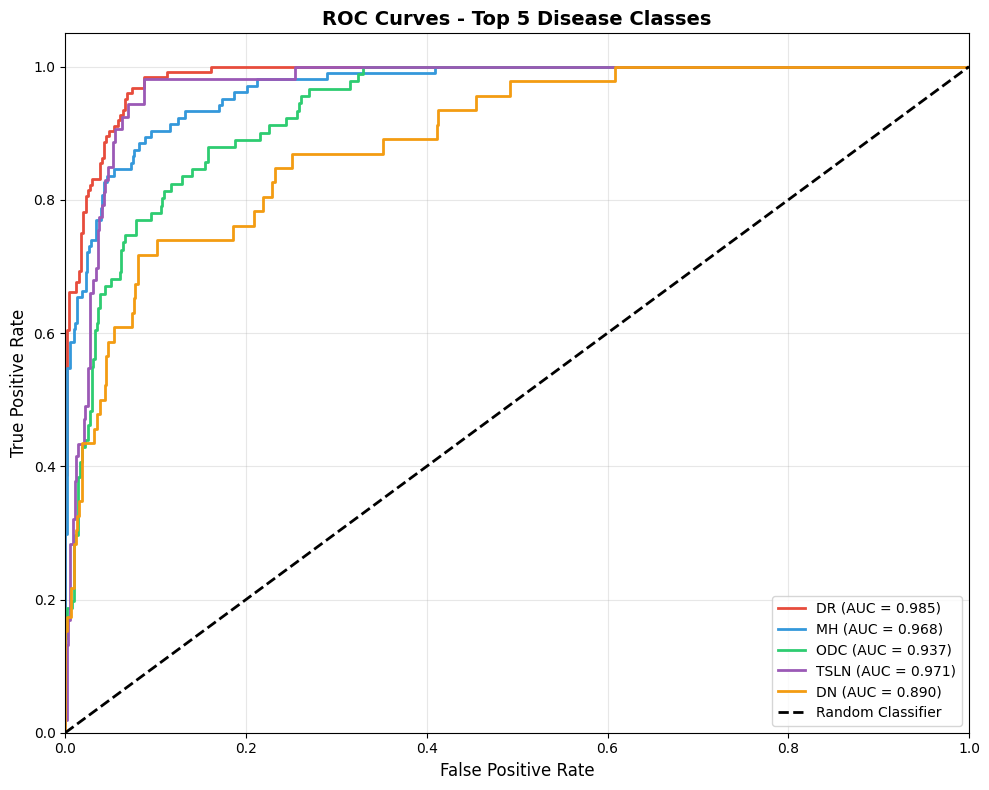

In [ ]:
# 5. ROC Curve - Top 5 hastalık sınıfları için
from sklearn.metrics import roc_curve, auc

top_5_classes = class_counts.nlargest(5).index.tolist()
top_5_indices = [class_names.index(c) for c in top_5_classes]

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']

for idx, (class_idx, class_name, color) in enumerate(zip(top_5_indices, top_5_classes, colors)):
    fpr, tpr, _ = roc_curve(all_labels[:, class_idx].numpy(), all_preds[:, class_idx].numpy())
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{class_name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Top 5 Disease Classes', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/roc_curves_top5.png', dpi=300, bbox_inches='tight')
plt.show()

In [138]:
# 6. Özet Performans Metrikleri Tablosu
from sklearn.metrics import classification_report

# Ortalama metrikler
avg_precision = test_result['precision'].mean().item()
avg_recall = test_result['recall'].mean().item()
avg_f1 = test_result['f1'].mean().item()

# Sadece pozitif örneği olan sınıflar için (daha gerçekçi)
nonzero_mask = test_result['f1'] > 0
avg_precision_nonzero = test_result['precision'][nonzero_mask].mean().item()
avg_recall_nonzero = test_result['recall'][nonzero_mask].mean().item()
avg_f1_nonzero = test_result['f1'][nonzero_mask].mean().item()

print("=" * 60)
print("📊 MODEL PERFORMANS ÖZETİ")
print("=" * 60)
print(f"\n🎯 Test Seti Sonuçları:")
print(f"   • Test Loss: {test_res['loss']:.4f}")
print(f"   • Test Accuracy: {test_res['acc']:.3f} ({test_res['acc']*100:.1f}%)")
print(f"\n📈 Tüm Sınıflar Üzerinden Ortalama:")
print(f"   • Macro Precision: {avg_precision:.3f}")
print(f"   • Macro Recall: {avg_recall:.3f}")
print(f"   • Macro F1 Score: {avg_f1:.3f}")
print(f"\n📈 Aktif Sınıflar Üzerinden Ortalama (F1 > 0):")
print(f"   • Macro Precision: {avg_precision_nonzero:.3f}")
print(f"   • Macro Recall: {avg_recall_nonzero:.3f}")
print(f"   • Macro F1 Score: {avg_f1_nonzero:.3f}")
print(f"\n📋 Toplam Sınıf Sayısı: {len(class_names)}")
print(f"   • Öğrenilen sınıflar (F1 > 0): {nonzero_mask.sum().item()}")
print(f"   • Öğrenilemeyen sınıflar (F1 = 0): {(~nonzero_mask).sum().item()}")
print("=" * 60)

📊 MODEL PERFORMANS ÖZETİ

🎯 Test Seti Sonuçları:
   • Test Loss: 0.0950
   • Test Accuracy: 0.966 (96.6%)

📈 Tüm Sınıflar Üzerinden Ortalama:
   • Macro Precision: 0.767
   • Macro Recall: 0.464
   • Macro F1 Score: 0.556

📈 Aktif Sınıflar Üzerinden Ortalama (F1 > 0):
   • Macro Precision: 0.818
   • Macro Recall: 0.495
   • Macro F1 Score: 0.593

📋 Toplam Sınıf Sayısı: 16
   • Öğrenilen sınıflar (F1 > 0): 15
   • Öğrenilemeyen sınıflar (F1 = 0): 1


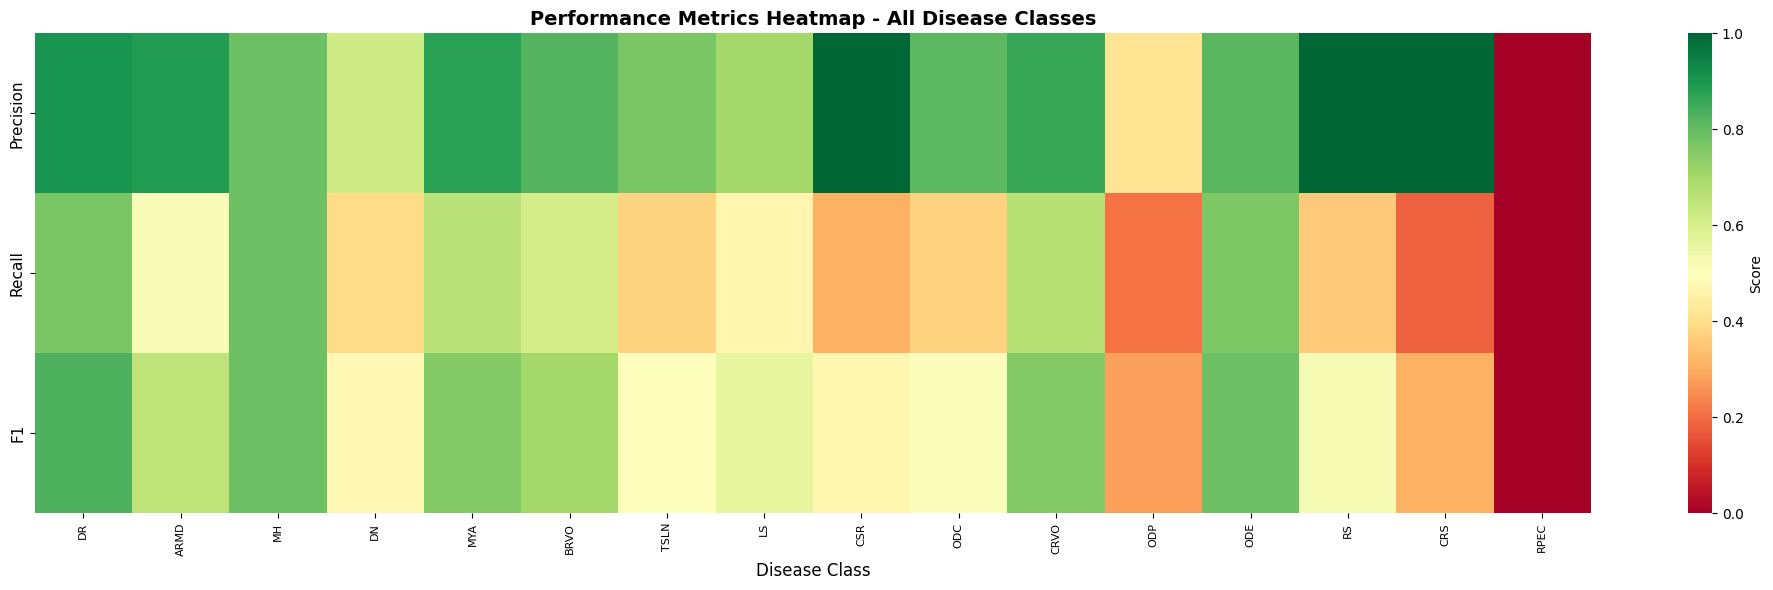

In [ ]:
# 7. Heatmap - Tüm Sınıflar için Precision/Recall/F1
fig, ax = plt.subplots(figsize=(20, 6))

# Metrikleri birleştir
metrics_data = np.stack([
    test_result['precision'].numpy(),
    test_result['recall'].numpy(),
    test_result['f1'].numpy()
])

sns.heatmap(metrics_data, annot=False, cmap='RdYlGn', ax=ax,
            xticklabels=class_names, yticklabels=['Precision', 'Recall', 'F1'],
            vmin=0, vmax=1, cbar_kws={'label': 'Score'})

ax.set_title('Performance Metrics Heatmap - All Disease Classes', fontsize=14, fontweight='bold')
ax.set_xlabel('Disease Class', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig('images/metrics_heatmap_all_classes.png', dpi=300, bbox_inches='tight')
plt.show()

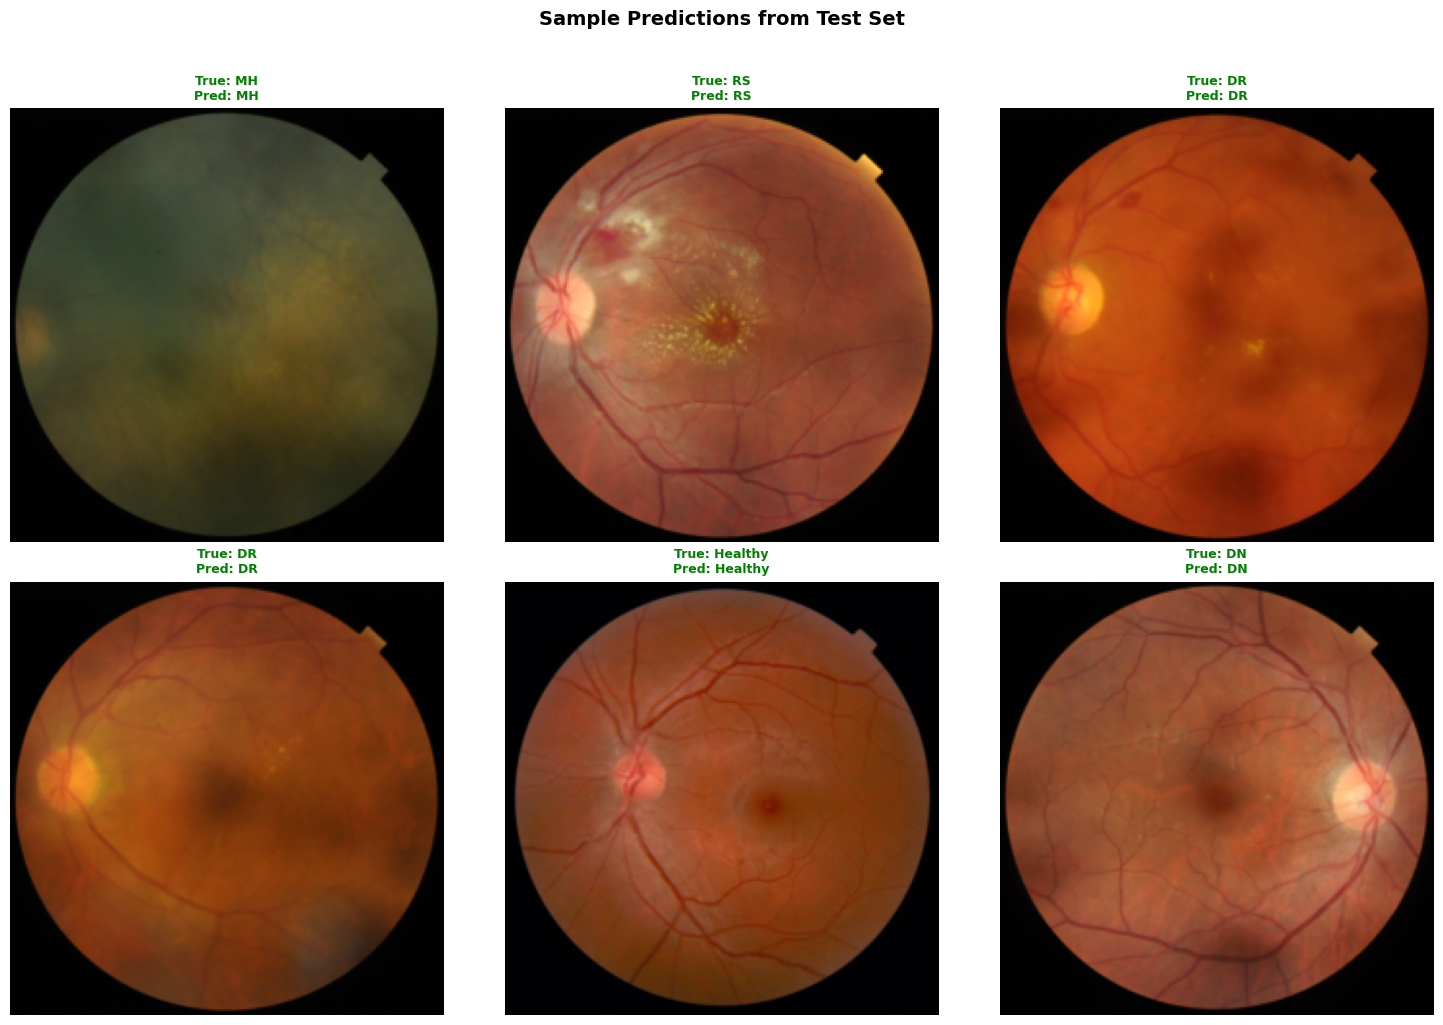

In [ ]:
# 8. Örnek Tahminler - Doğru ve Yanlış Örnekler Görselleştirme
import random

# Test setinden bazı örnekler al
sample_indices = random.sample(range(len(test_data)), 6)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    img, true_label = test_data[sample_idx]

    # Tahmin yap
    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred = torch.sigmoid(pred).cpu().squeeze()

    # Görüntüyü denormalize et
    mean = torch.tensor(PRET_MEANS).view(3, 1, 1)
    std = torch.tensor(PRET_STDS).view(3, 1, 1)
    img_display = img * std + mean
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)

    # Gerçek ve tahmin edilen hastalıklar
    true_diseases = [class_names[i] for i in range(len(class_names)) if true_label[i] == 1]
    pred_diseases = [class_names[i] for i in range(len(class_names)) if pred[i] > 0.5]

    axes[idx].imshow(img_display)
    axes[idx].axis('off')

    true_str = ', '.join(true_diseases) if true_diseases else 'Healthy'
    pred_str = ', '.join(pred_diseases) if pred_diseases else 'Healthy'

    # Başlık rengini belirle
    is_correct = set(true_diseases) == set(pred_diseases)
    color = 'green' if is_correct else 'red'

    axes[idx].set_title(f'True: {true_str}\nPred: {pred_str}',
                        fontsize=9, color=color, fontweight='bold')

plt.suptitle('Sample Predictions from Test Set', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

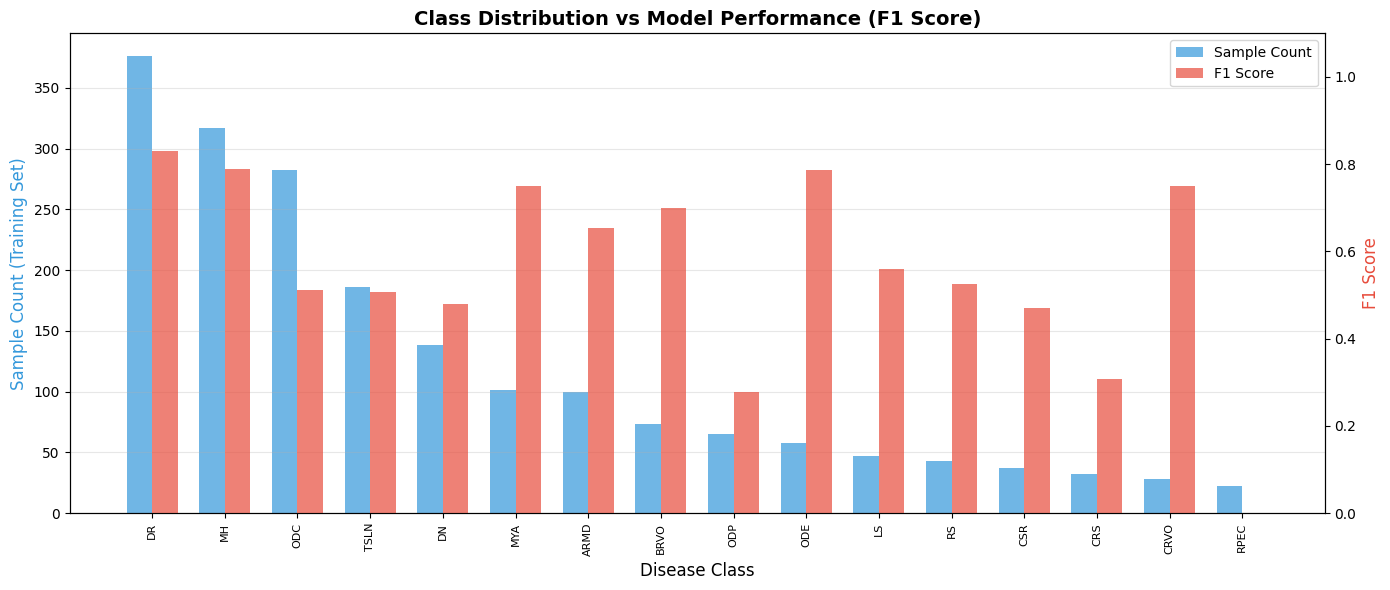

In [ ]:
# 9. Sınıf Dağılımı vs Model Performansı Karşılaştırması
fig, ax = plt.subplots(figsize=(14, 6))

# Sınıf sayıları ve F1 skorları
class_counts_sorted = class_counts.sort_values(ascending=False)
f1_sorted = [test_result['f1'][class_names.index(c)].item() for c in class_counts_sorted.index]

x = np.arange(len(class_counts_sorted))
width = 0.35

# İkili eksen
ax2 = ax.twinx()

bars1 = ax.bar(x - width/2, class_counts_sorted.values, width, label='Sample Count', color='#3498db', alpha=0.7)
bars2 = ax2.bar(x + width/2, f1_sorted, width, label='F1 Score', color='#e74c3c', alpha=0.7)

ax.set_xlabel('Disease Class', fontsize=12)
ax.set_ylabel('Sample Count (Training Set)', fontsize=12, color='#3498db')
ax2.set_ylabel('F1 Score', fontsize=12, color='#e74c3c')
ax.set_title('Class Distribution vs Model Performance (F1 Score)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_counts_sorted.index, rotation=90, fontsize=8)

# Legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('images/class_distribution_vs_performance.png', dpi=300, bbox_inches='tight')
plt.show()

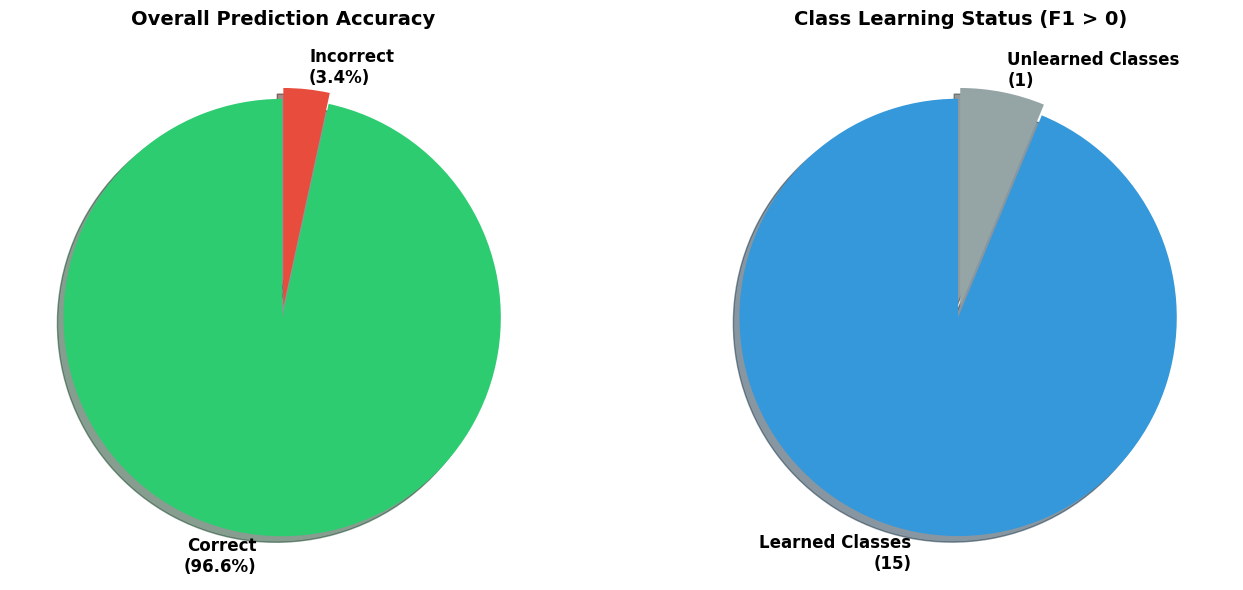


✅ Tüm grafikler başarıyla oluşturuldu ve kaydedildi!
📁 Kaydedilen dosyalar:
   • training_curves.png
   • confusion_matrices_top10.png
   • precision_recall_f1_top15.png
   • roc_curves_top5.png
   • metrics_heatmap_all_classes.png
   • sample_predictions.png
   • class_distribution_vs_performance.png
   • overall_performance_pie.png


In [ ]:
# 10. Pie Chart - Genel Model Başarısı
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sol: Accuracy pie chart
accuracy = test_res['acc']
sizes_acc = [accuracy, 1 - accuracy]
labels_acc = [f'Correct\n({accuracy*100:.1f}%)', f'Incorrect\n({(1-accuracy)*100:.1f}%)']
colors_acc = ['#2ecc71', '#e74c3c']
explode_acc = (0.05, 0)

axes[0].pie(sizes_acc, explode=explode_acc, labels=labels_acc, colors=colors_acc,
            autopct='', shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('Overall Prediction Accuracy', fontsize=14, fontweight='bold')

# Sağ: Öğrenilen vs öğrenilemeyen sınıflar
learned = nonzero_mask.sum().item()
not_learned = (~nonzero_mask).sum().item()
sizes_class = [learned, not_learned]
labels_class = [f'Learned Classes\n({learned})', f'Unlearned Classes\n({not_learned})']
colors_class = ['#3498db', '#95a5a6']
explode_class = (0.05, 0)

axes[1].pie(sizes_class, explode=explode_class, labels=labels_class, colors=colors_class,
            autopct='', shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Class Learning Status (F1 > 0)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('images/overall_performance_pie.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Tüm grafikler başarıyla oluşturuldu ve kaydedildi!")
print("📁 Kaydedilen dosyalar (images/ klasörüne):")
print("   • images/training_curves.png")
print("   • images/confusion_matrices_top10.png")
print("   • images/precision_recall_f1_top15.png")
print("   • images/roc_curves_top5.png")
print("   • images/metrics_heatmap_all_classes.png")
print("   • images/sample_predictions.png")
print("   • images/class_distribution_vs_performance.png")
print("   • images/overall_performance_pie.png")

# 📦 Model Export - Web Uygulaması İçin

Bu bölüm eğitilmiş modeli ve gerekli dosyaları web uygulamasında kullanmak üzere kaydeder.

In [143]:
# ==========================================
# 11. MODEL EXPORT - WEB UYGULAMASI İÇİN
# ==========================================
import json
import os

# Export dizini oluştur
EXPORT_DIR = 'model_export'
os.makedirs(EXPORT_DIR, exist_ok=True)

# 1. Sınıf isimlerini kaydet (JSON formatında)
class_names = train_label_df.drop(columns=['ID', 'Disease_Risk']).columns.tolist()
class_info = {
    'class_names': class_names,
    'num_classes': len(class_names),
    'model_architecture': 'ConvNeXt-Tiny',
    'input_size': 224,
    'threshold': 0.5
}

with open(os.path.join(EXPORT_DIR, 'class_info.json'), 'w') as f:
    json.dump(class_info, f, indent=2)

print(f"✅ Sınıf bilgileri kaydedildi: {EXPORT_DIR}/class_info.json")
print(f"   Toplam sınıf sayısı: {len(class_names)}")
print(f"   Sınıflar: {class_names}")

✅ Sınıf bilgileri kaydedildi: model_export/class_info.json
   Toplam sınıf sayısı: 16
   Sınıflar: ['DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN', 'LS', 'CSR', 'ODC', 'CRVO', 'ODP', 'ODE', 'RS', 'CRS', 'RPEC']


In [144]:
# 2. En iyi modeli yükle ve final olarak kaydet
# BEST_MODEL_V2 değişkeni eğitim sırasında tanımlandı

print(f"En iyi model dosyası: {BEST_MODEL_V2}")

# Modeli yükle
model_v2.load_state_dict(torch.load(BEST_MODEL_V2, map_location=device))
model_v2.eval()

# Final model olarak kaydet (daha anlamlı isimle)
FINAL_MODEL_PATH = os.path.join(EXPORT_DIR, 'retina_disease_classifier.pth')

# Sadece model ağırlıklarını kaydet (state_dict)
torch.save(model_v2.state_dict(), FINAL_MODEL_PATH)
print(f"✅ Model ağırlıkları kaydedildi: {FINAL_MODEL_PATH}")

# Model boyutunu göster
model_size = os.path.getsize(FINAL_MODEL_PATH) / (1024 * 1024)
print(f"   Model boyutu: {model_size:.2f} MB")

En iyi model dosyası: convnext_threshold_opt_cp_19.pth
✅ Model ağırlıkları kaydedildi: model_export/retina_disease_classifier.pth
   Model boyutu: 106.24 MB


In [145]:
# 3. Tam model olarak kaydet (architecture + weights + thresholds) - Kolay yükleme için
# Bu yöntem modeli doğrudan yükleyebilmeyi sağlar

FULL_MODEL_PATH = os.path.join(EXPORT_DIR, 'retina_disease_classifier_full.pth')

# Model + metadata + optimal thresholds birlikte kaydet
checkpoint = {
    'model_state_dict': model_v2.state_dict(),
    'class_names': class_names,
    'num_classes': len(class_names),
    'input_size': 224,
    'architecture': 'convnext_tiny',
    'optimal_thresholds': best_thresholds,  # Per-class optimal thresholds
    'default_threshold': 0.5
}

torch.save(checkpoint, FULL_MODEL_PATH)
print(f"✅ Tam model (checkpoint + thresholds) kaydedildi: {FULL_MODEL_PATH}")

checkpoint_size = os.path.getsize(FULL_MODEL_PATH) / (1024 * 1024)
print(f"   Checkpoint boyutu: {checkpoint_size:.2f} MB")

# Optimal thresholds'ı ayrı JSON olarak da kaydet
import shutil
shutil.copy('best_thresholds.json', os.path.join(EXPORT_DIR, 'optimal_thresholds.json'))
print(f"✅ Optimal thresholds kaydedildi: {EXPORT_DIR}/optimal_thresholds.json")

✅ Tam model (checkpoint + thresholds) kaydedildi: model_export/retina_disease_classifier_full.pth
   Checkpoint boyutu: 106.24 MB
✅ Optimal thresholds kaydedildi: model_export/optimal_thresholds.json


In [146]:
# 4. Inference Script - Optimal Thresholds ile
inference_code = '''
# ==========================================
# RETINA DISEASE CLASSIFIER - INFERENCE CODE
# ==========================================
# Bu kodu web uygulamanızda kullanabilirsiniz
# Optimal per-class thresholds ile False Positive azaltılmış versiyon

import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
import json

class RetinaClassifier:
    def __init__(self, model_path, class_info_path, thresholds_path=None, device='cpu'):
        """
        Retina hastalık sınıflandırıcı (Optimal Thresholds destekli)

        Args:
            model_path: Model checkpoint dosyasının yolu (.pth)
            class_info_path: class_info.json dosyasının yolu
            thresholds_path: optimal_thresholds.json dosyasının yolu (opsiyonel)
            device: 'cpu' veya 'cuda'
        """
        self.device = torch.device(device)

        # Sınıf bilgilerini yükle
        with open(class_info_path, 'r') as f:
            self.class_info = json.load(f)

        self.class_names = self.class_info['class_names']
        self.num_classes = self.class_info['num_classes']

        # Optimal thresholds yükle
        self.thresholds = {}
        checkpoint = torch.load(model_path, map_location=self.device)

        # Önce checkpoint'tan thresholds almaya çalış
        if 'optimal_thresholds' in checkpoint:
            self.thresholds = checkpoint['optimal_thresholds']
            print("✅ Optimal thresholds checkpoint'tan yüklendi")
        # Yoksa ayrı dosyadan yükle
        elif thresholds_path:
            with open(thresholds_path, 'r') as f:
                self.thresholds = json.load(f)
            print("✅ Optimal thresholds JSON'dan yüklendi")
        else:
            # Default 0.5 kullan
            self.thresholds = {name: 0.5 for name in self.class_names}
            print("⚠️ Optimal thresholds bulunamadı, 0.5 kullanılıyor")

        # Modeli oluştur
        self.model = self._create_model()

        # Checkpoint yükle
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model.load_state_dict(checkpoint)

        self.model.eval()
        self.model.to(self.device)

        # Transform tanımla
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        print(f"Model yüklendi: {self.num_classes} sınıf")
        print(f"Threshold aralığı: {min(self.thresholds.values()):.3f} - {max(self.thresholds.values()):.3f}")

    def _create_model(self):
        """ConvNeXt-Tiny modelini oluştur"""
        model = models.convnext_tiny(weights=None)
        model.classifier[2] = nn.Linear(
            model.classifier[2].in_features,
            self.num_classes
        )
        return model

    def predict(self, image_path, use_optimal_thresholds=True):
        """
        Tek bir görüntü için tahmin yap (per-class optimal thresholds ile)

        Args:
            image_path: Görüntü dosyasının yolu veya PIL Image
            use_optimal_thresholds: True ise per-class optimal thresholds kullan

        Returns:
            dict: {
                'predictions': [(sınıf_adı, olasılık, threshold), ...],
                'detected_diseases': [sınıf_adı1, sınıf_adı2, ...],
                'raw_probabilities': {sınıf: olasılık, ...}
            }
        """
        # Görüntüyü yükle
        if isinstance(image_path, str):
            image = Image.open(image_path).convert('RGB')
        else:
            image = image_path.convert('RGB')

        # Transform uygula
        img_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # Tahmin yap
        with torch.no_grad():
            output = self.model(img_tensor)
            probabilities = torch.sigmoid(output).squeeze().cpu().numpy()

        # Sonuçları hazırla (per-class thresholds ile)
        predictions = []
        detected_diseases = []

        for i, (name, prob) in enumerate(zip(self.class_names, probabilities)):
            threshold = self.thresholds.get(name, 0.5) if use_optimal_thresholds else 0.5
            is_detected = prob >= threshold

            predictions.append({
                'disease': name,
                'probability': float(prob),
                'threshold': threshold,
                'detected': is_detected
            })

            if is_detected:
                detected_diseases.append(name)

        # Olasılığa göre sırala
        predictions.sort(key=lambda x: x['probability'], reverse=True)

        return {
            'predictions': predictions,
            'detected_diseases': detected_diseases,
            'raw_probabilities': {name: float(prob) for name, prob in zip(self.class_names, probabilities)},
            'num_detected': len(detected_diseases)
        }

    def predict_top_k(self, image_path, k=5):
        """En yüksek k tahmin döndür"""
        result = self.predict(image_path, use_optimal_thresholds=False)
        sorted_probs = sorted(
            result['raw_probabilities'].items(),
            key=lambda x: x[1],
            reverse=True
        )
        return sorted_probs[:k]


# Kullanım örneği:
if __name__ == "__main__":
    # Classifier oluştur
    classifier = RetinaClassifier(
        model_path='model_export/retina_disease_classifier_full.pth',
        class_info_path='model_export/class_info.json',
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # Tahmin yap
    result = classifier.predict('test_image.png')

    print("Tespit edilen hastalıklar:")
    for disease, prob in result['predictions']:
        print(f"  - {disease}: {prob:.1%}")

    # Top 5 tahmin
    print("\\nTop 5 tahmin:")
    for disease, prob in classifier.predict_top_k('test_image.png', k=5):
        print(f"  - {disease}: {prob:.1%}")
'''

# Inference script'i dosyaya kaydet
inference_script_path = os.path.join(EXPORT_DIR, 'inference.py')
with open(inference_script_path, 'w', encoding='utf-8') as f:
    f.write(inference_code)

print(f"✅ Inference script kaydedildi: {inference_script_path}")

✅ Inference script kaydedildi: model_export/inference.py


In [147]:
# 5. Flask Web App Template - Basit bir web arayüzü için
flask_app_code = '''
# ==========================================
# RETINA DISEASE CLASSIFIER - FLASK WEB APP
# ==========================================
# pip install flask torch torchvision pillow

from flask import Flask, render_template, request, jsonify
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
import json
import io
import base64
import os

app = Flask(__name__)

# Model yükleme
class RetinaClassifier:
    def __init__(self, model_path, class_info_path):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        with open(class_info_path, 'r') as f:
            self.class_info = json.load(f)

        self.class_names = self.class_info['class_names']
        self.num_classes = len(self.class_names)

        # Model oluştur
        self.model = models.convnext_tiny(weights=None)
        self.model.classifier[2] = nn.Linear(
            self.model.classifier[2].in_features,
            self.num_classes
        )

        # Ağırlıkları yükle
        checkpoint = torch.load(model_path, map_location=self.device)
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model.load_state_dict(checkpoint)

        self.model.eval()
        self.model.to(self.device)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, image, threshold=0.3):
        img_tensor = self.transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            output = self.model(img_tensor)
            probs = torch.sigmoid(output).squeeze().cpu().numpy()

        results = []
        for i, prob in enumerate(probs):
            results.append({
                'disease': self.class_names[i],
                'probability': float(prob),
                'detected': prob >= threshold
            })

        results.sort(key=lambda x: x['probability'], reverse=True)
        return results

# Classifier'ı global olarak yükle
classifier = RetinaClassifier(
    model_path='model_export/retina_disease_classifier_full.pth',
    class_info_path='model_export/class_info.json'
)

# HTML Template
HTML_TEMPLATE = """
<!DOCTYPE html>
<html>
<head>
    <title>Retina Disease Classifier</title>
    <style>
        body { font-family: Arial, sans-serif; max-width: 800px; margin: 0 auto; padding: 20px; background: #f5f5f5; }
        .container { background: white; padding: 30px; border-radius: 10px; box-shadow: 0 2px 10px rgba(0,0,0,0.1); }
        h1 { color: #2c3e50; text-align: center; }
        .upload-area { border: 2px dashed #3498db; padding: 40px; text-align: center; margin: 20px 0; border-radius: 10px; }
        .upload-area:hover { background: #ecf0f1; }
        #preview { max-width: 100%; max-height: 400px; margin: 20px auto; display: block; }
        .results { margin-top: 20px; }
        .disease-item { display: flex; justify-content: space-between; padding: 10px; border-bottom: 1px solid #eee; }
        .disease-item.detected { background: #e8f5e9; }
        .probability-bar { height: 20px; background: #3498db; border-radius: 10px; }
        .btn { background: #3498db; color: white; padding: 10px 30px; border: none; border-radius: 5px; cursor: pointer; font-size: 16px; }
        .btn:hover { background: #2980b9; }
        .loading { display: none; text-align: center; padding: 20px; }
    </style>
</head>
<body>
    <div class="container">
        <h1>🔬 Retina Hastalık Sınıflandırıcı</h1>
        <p style="text-align: center;">Retina görüntüsü yükleyerek hastalık taraması yapın</p>

        <div class="upload-area" onclick="document.getElementById('fileInput').click()">
            <p>📤 Görüntü yüklemek için tıklayın veya sürükleyin</p>
            <input type="file" id="fileInput" accept="image/*" style="display: none;" onchange="handleFile(this)">
        </div>

        <img id="preview" style="display: none;">

        <div style="text-align: center;">
            <button class="btn" onclick="analyze()" id="analyzeBtn" style="display: none;">🔍 Analiz Et</button>
        </div>

        <div class="loading" id="loading">⏳ Analiz ediliyor...</div>

        <div class="results" id="results"></div>
    </div>

    <script>
        let currentFile = null;

        function handleFile(input) {
            if (input.files && input.files[0]) {
                currentFile = input.files[0];
                const reader = new FileReader();
                reader.onload = function(e) {
                    document.getElementById('preview').src = e.target.result;
                    document.getElementById('preview').style.display = 'block';
                    document.getElementById('analyzeBtn').style.display = 'inline-block';
                }
                reader.readAsDataURL(input.files[0]);
            }
        }

        async function analyze() {
            if (!currentFile) return;

            document.getElementById('loading').style.display = 'block';
            document.getElementById('results').innerHTML = '';

            const formData = new FormData();
            formData.append('image', currentFile);

            try {
                const response = await fetch('/predict', {
                    method: 'POST',
                    body: formData
                });
                const data = await response.json();
                displayResults(data.results);
            } catch (error) {
                alert('Hata oluştu: ' + error);
            }

            document.getElementById('loading').style.display = 'none';
        }

        function displayResults(results) {
            let html = '<h3>📊 Analiz Sonuçları</h3>';
            html += '<p>Tespit edilen hastalıklar (>30% olasılık):</p>';

            for (const r of results) {
                const barWidth = (r.probability * 100).toFixed(0);
                const detected = r.detected ? 'detected' : '';
                const emoji = r.detected ? '⚠️' : '';

                html += `
                    <div class="disease-item ${detected}">
                        <span>${emoji} ${r.disease}</span>
                        <span>${(r.probability * 100).toFixed(1)}%</span>
                    </div>
                    <div style="background: #eee; border-radius: 10px; margin-bottom: 10px;">
                        <div class="probability-bar" style="width: ${barWidth}%"></div>
                    </div>
                `;
            }

            document.getElementById('results').innerHTML = html;
        }
    </script>
</body>
</html>
"""

@app.route('/')
def index():
    return HTML_TEMPLATE

@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({'error': 'No image provided'}), 400

    file = request.files['image']
    image = Image.open(io.BytesIO(file.read())).convert('RGB')

    results = classifier.predict(image)

    return jsonify({'results': results})

if __name__ == '__main__':
    print("🚀 Retina Disease Classifier Web App")
    print("   http://localhost:5000")
    app.run(debug=True, port=5000)
'''

# Flask app'i dosyaya kaydet
flask_app_path = os.path.join(EXPORT_DIR, 'app.py')
with open(flask_app_path, 'w', encoding='utf-8') as f:
    f.write(flask_app_code)

print(f"✅ Flask Web App kaydedildi: {flask_app_path}")

✅ Flask Web App kaydedildi: model_export/app.py


In [148]:
# 6. Requirements dosyası oluştur
requirements = """# Retina Disease Classifier - Requirements
torch>=2.0.0
torchvision>=0.15.0
flask>=2.3.0
pillow>=9.0.0
numpy>=1.24.0
"""

requirements_path = os.path.join(EXPORT_DIR, 'requirements.txt')
with open(requirements_path, 'w') as f:
    f.write(requirements)

print(f"✅ Requirements dosyası kaydedildi: {requirements_path}")

✅ Requirements dosyası kaydedildi: model_export/requirements.txt


In [149]:
# 7. Export özeti ve kullanım talimatları
print("=" * 60)
print("📦 MODEL EXPORT TAMAMLANDI!")
print("=" * 60)

print(f"""
📁 Oluşturulan dosyalar ({EXPORT_DIR}/ klasöründe):

   1. retina_disease_classifier.pth     - Model ağırlıkları (state_dict)
   2. retina_disease_classifier_full.pth - Tam checkpoint (model + metadata)
   3. class_info.json                    - Sınıf isimleri ve config
   4. inference.py                       - Python inference script
   5. app.py                             - Flask web uygulaması
   6. requirements.txt                   - Gerekli Python paketleri

🚀 Web Uygulamasını Çalıştırma:

   1. model_export klasörünü bilgisayarına indir
   2. Terminal aç ve klasöre git:
      cd model_export

   3. Gerekli paketleri yükle:
      pip install -r requirements.txt

   4. Web uygulamasını başlat:
      python app.py

   5. Tarayıcıda aç:
      http://localhost:5000

💡 Python'da Kullanım:

   from inference import RetinaClassifier

   classifier = RetinaClassifier(
       model_path='retina_disease_classifier_full.pth',
       class_info_path='class_info.json'
   )

   result = classifier.predict('retina_image.png')
   print(result['predictions'])

📊 Model Bilgileri:
   - Mimari: ConvNeXt-Tiny
   - Sınıf sayısı: {len(class_names)}
   - Giriş boyutu: 224x224
   - Threshold: 0.5
""")

# Colab için: Dosyaları indir
try:
    from google.colab import files
    import shutil

    # ZIP dosyası oluştur
    shutil.make_archive('model_export', 'zip', EXPORT_DIR)
    print("📥 Colab'da dosyaları indirmek için aşağıdaki hücreyi çalıştır:")
    print("   files.download('model_export.zip')")
except:
    pass

📦 MODEL EXPORT TAMAMLANDI!

📁 Oluşturulan dosyalar (model_export/ klasöründe):

   1. retina_disease_classifier.pth     - Model ağırlıkları (state_dict)
   2. retina_disease_classifier_full.pth - Tam checkpoint (model + metadata)
   3. class_info.json                    - Sınıf isimleri ve config
   4. inference.py                       - Python inference script
   5. app.py                             - Flask web uygulaması
   6. requirements.txt                   - Gerekli Python paketleri

🚀 Web Uygulamasını Çalıştırma:

   1. model_export klasörünü bilgisayarına indir
   2. Terminal aç ve klasöre git:
      cd model_export

   3. Gerekli paketleri yükle:
      pip install -r requirements.txt

   4. Web uygulamasını başlat:
      python app.py

   5. Tarayıcıda aç:
      http://localhost:5000

💡 Python'da Kullanım:

   from inference import RetinaClassifier

   classifier = RetinaClassifier(
       model_path='retina_disease_classifier_full.pth',
       class_info_path='class_info.j

In [150]:
# 8. (Opsiyonel) Colab'da ZIP dosyasını indir
try:
    from google.colab import files
    files.download('model_export.zip')
    print("✅ model_export.zip indiriliyor...")
except:
    print("ℹ️ Colab dışında çalışıyorsunuz. model_export klasörünü manuel olarak kopyalayın.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ model_export.zip indiriliyor...
